In [1]:
import db_dtypes
import matplotlib.pyplot as plt
import os
import pandas as pd
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np
import seaborn as sns

In [2]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [3]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

In [4]:
query_job = bigquery_client.query(query)
unemployment_data = query_job.to_dataframe()

In [5]:
unemployment_data = unemployment_data.drop_duplicates()

In [6]:
unemployment_data.fillna(0, inplace=True)

In [7]:
unemployment_data = unemployment_data.filter(['uu_id', 'week_number','total_claims','edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs','race_amerindian', 'race_asian', 'race_black','race_white'])

In [8]:
unemployment_data.isnull().sum()

uu_id                0
week_number          0
total_claims         0
edu_8th_or_less      0
edu_grades_9_11      0
edu_hs_grad_equiv    0
edu_post_hs          0
race_amerindian      0
race_asian           0
race_black           0
race_white           0
dtype: int64

In [9]:
unemployment_data = unemployment_data.sort_values(by=['uu_id','week_number']).reset_index()

In [10]:
unemployment_data = unemployment_data.drop('index', axis=1)

In [11]:
unemployment_data.head()

uu_id  week_number  total_claims  \
0  001cd9ae23064d7f0fd3cd327c873d8d           31            34   
1  001cd9ae23064d7f0fd3cd327c873d8d           33            10   
2  001cd9ae23064d7f0fd3cd327c873d8d           34            25   
3  001cd9ae23064d7f0fd3cd327c873d8d           35            10   
4  001cd9ae23064d7f0fd3cd327c873d8d           36            10   

   edu_8th_or_less  edu_grades_9_11  edu_hs_grad_equiv  edu_post_hs  \
0                0                0                 30            0   
1                0                0                  0            0   
2                0                0                  0            0   
3                0                0                  0            0   
4                0                0                  0            0   

   race_amerindian  race_asian  race_black  race_white  
0                0           0           0          34  
1                0           0           0          10  
2                0           0           0           0  
3                0           0           0           0  
4                0           0           0           0

In [12]:
uuids = unemployment_data.uu_id.unique()

In [13]:
uuids[:10]

array(['001cd9ae23064d7f0fd3cd327c873d8d',
       '005be9532fd717dc36d4be318fd9ad25',
       '007c1caccff1fbb3a0b8a10790f77141',
       '009683350b175edfc6414d664e4ba873',
       '00f962ce727b8dbbf20925abd5a253dd',
       '02a7b845ab6b3fc2c09a50cdc486db2a',
       '03ba3a9a63be1a5423457246f2846292',
       '050a624d618a68e43fe31189909c644f',
       '05298117cbe0fd69f04f89c83aaac091',
       '05f47cc80d60a67d61e891e2b90c2045'], dtype=object)

In [14]:
def predict_claims(uuid, week):
    data = unemployment_data[unemployment_data.uu_id == uuid]
    plt.plot(data.week_number, data.total_claims)
    plt.show()
    
    # new = pd.DataFrame({'uu_id':uuid, 'week_number': 39, 'total_claims': data.total_claims.median(), 'edu_8th_or_less':0, 'edu_grades_9_11': 0, 'edu_hs_grad_equiv':0, 'edu_post_hs':0,
    #                     'race_amerindian':0, 'race_asian':0, 'race_black':0, 'race_white':0}, index=[0])
    
    data.loc[len(data.index)] = [uuid, week, data.total_claims.median(), 0,0,0,0,0,0,0,0]
    data
    
    X = data.drop(['uu_id','total_claims'], axis = 1)
    y = data[['total_claims']]
    
    
    
    # Splitting data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 101)
    # Train the Model

    regr = RandomForestRegressor(n_estimators = 10, max_depth = 10, random_state = 101)
    regr.fit(X_train, y_train.values.ravel())
    
    predictions = regr.predict(X_test)
    
    result = X_test
    result['total_claims'] = y_test
    result['prediction'] = predictions.tolist()
    
    x_axis = X_test.week_number
    
    plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
    plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')

    plt.xlabel('Week Number')
    plt.ylabel('Total Claims')
    plt.title('Tract: '+uuid)

    plt.grid(color = '#D3D3D3', linestyle = 'solid')

    plt.legend(loc = 'lower right')

    plt.show()
    
    
    return result.sort_values(by = 'week_number')

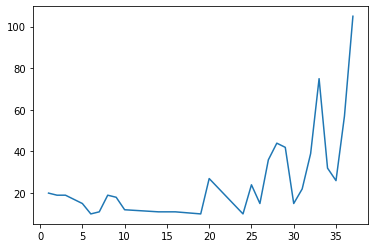

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/3335713731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/3335713731.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


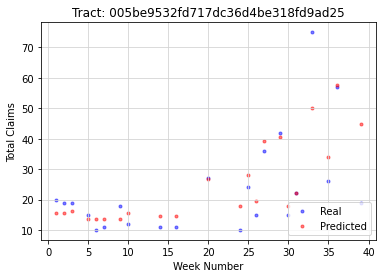

week_number  edu_8th_or_less  edu_grades_9_11  edu_hs_grad_equiv  \
6             1                0                0                  0   
7             2                0                0                  0   
8             3                0                0                 10   
9             5                0                0                  0   
10            6                0                0                  0   
11            7                0                0                  0   
13            9                0                0                  0   
14           10                0                0                  0   
15           14                0                0                  0   
16           16                0                0                  0   
18           20                0                0                  0   
19           24                0                0                  0   
20           25                0                0                  0   
21           26                0                0                  0   
22           27                0                0                 23   
24           29                0                0                 28   
25           30                0                0                  0   
26           31                0                0                 10   
28           33                0                0                 44   
30           35                0                0                 15   
31           36                0                0                 25   
27           39                0                0                  0   

    edu_post_hs  race_amerindian  race_asian  race_black  race_white  \
6             0                0           0           0           0   
7             0                0           0           0           0   
8             0                0           0           0          19   
9             0                0           0           0          15   
10            0                0           0           0          10   
11            0                0           0           0          11   
13            0                0           0           0          18   
14            0                0           0           0           0   
15            0                0           0           0           0   
16            0                0           0           0           0   
18            0                0           0           0          27   
19            0                0           0           0          10   
20            0                0           0           0          24   
21            0                0           0           0           0   
22            0                0           0           0          32   
24           10                0           0           0          39   
25            0                0           0           0          15   
26            0                0           0           0           0   
28           16                0           0           0          62   
30            0                0           0           0           0   
31           17                0           0           0          52   
27            0                0           0           0           0   

    total_claims  prediction  
6             20        15.4  
7             19        15.4  
8             19        16.3  
9             15        13.6  
10            10        13.6  
11            11        13.6  
13            18        13.6  
14            12        15.4  
15            11        14.5  
16            11        14.5  
18            27        26.7  
19            10        17.8  
20            24        28.0  
21            15        19.6  
22            36        39.2  
24            42        40.4  
25            15        17.8  
26            22        22.3  
28            75        50.2  
30            26        34.0  
31            57        57.5  
27      

In [15]:
predict_claims('005be9532fd717dc36d4be318fd9ad25',39)

In [16]:
def predict_claims(uuid, week):
    data = unemployment_data[unemployment_data.uu_id == uuid].copy()
    plt.plot(data.week_number, data.total_claims)
    plt.show()
    
    # new = pd.DataFrame({'uu_id':uuid, 'week_number': 39, 'total_claims': data.total_claims.median(), 'edu_8th_or_less':0, 'edu_grades_9_11': 0, 'edu_hs_grad_equiv':0, 'edu_post_hs':0,
    #                     'race_amerindian':0, 'race_asian':0, 'race_black':0, 'race_white':0}, index=[0])
    
    data.loc[len(data.index)] = [uuid, week, data.total_claims.median(), 0,0,0,0,0,0,0,0]
    data
    
    X = data.drop(['uu_id','total_claims'], axis = 1)
    y = data[['total_claims']]
    
    
    
    # Splitting data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 101)
    # Train the Model

    regr = RandomForestRegressor(n_estimators = 10, max_depth = 10, random_state = 101)
    regr.fit(X_train, y_train.values.ravel())
    
    predictions = regr.predict(X_test)
    
    result = X_test
    result['total_claims'] = y_test
    result['prediction'] = predictions.tolist()
    
    x_axis = X_test.week_number
    
    plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
    plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')

    plt.xlabel('Week Number')
    plt.ylabel('Total Claims')
    plt.title('Tract: '+uuid)

    plt.grid(color = '#D3D3D3', linestyle = 'solid')

    plt.legend(loc = 'lower right')

    plt.show()
    
    
    return result.sort_values(by = 'week_number')

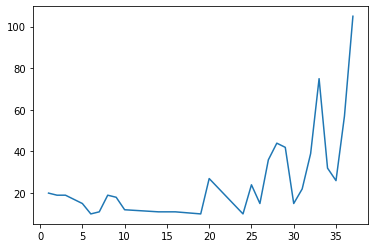

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/1891174767.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/1891174767.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


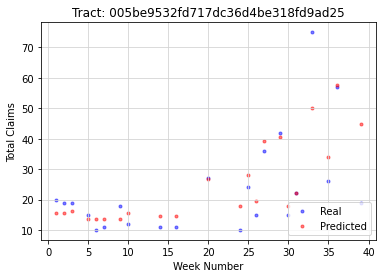

week_number  edu_8th_or_less  edu_grades_9_11  edu_hs_grad_equiv  \
6             1                0                0                  0   
7             2                0                0                  0   
8             3                0                0                 10   
9             5                0                0                  0   
10            6                0                0                  0   
11            7                0                0                  0   
13            9                0                0                  0   
14           10                0                0                  0   
15           14                0                0                  0   
16           16                0                0                  0   
18           20                0                0                  0   
19           24                0                0                  0   
20           25                0                0                  0   
21           26                0                0                  0   
22           27                0                0                 23   
24           29                0                0                 28   
25           30                0                0                  0   
26           31                0                0                 10   
28           33                0                0                 44   
30           35                0                0                 15   
31           36                0                0                 25   
27           39                0                0                  0   

    edu_post_hs  race_amerindian  race_asian  race_black  race_white  \
6             0                0           0           0           0   
7             0                0           0           0           0   
8             0                0           0           0          19   
9             0                0           0           0          15   
10            0                0           0           0          10   
11            0                0           0           0          11   
13            0                0           0           0          18   
14            0                0           0           0           0   
15            0                0           0           0           0   
16            0                0           0           0           0   
18            0                0           0           0          27   
19            0                0           0           0          10   
20            0                0           0           0          24   
21            0                0           0           0           0   
22            0                0           0           0          32   
24           10                0           0           0          39   
25            0                0           0           0          15   
26            0                0           0           0           0   
28           16                0           0           0          62   
30            0                0           0           0           0   
31           17                0           0           0          52   
27            0                0           0           0           0   

    total_claims  prediction  
6             20        15.4  
7             19        15.4  
8             19        16.3  
9             15        13.6  
10            10        13.6  
11            11        13.6  
13            18        13.6  
14            12        15.4  
15            11        14.5  
16            11        14.5  
18            27        26.7  
19            10        17.8  
20            24        28.0  
21            15        19.6  
22            36        39.2  
24            42        40.4  
25            15        17.8  
26            22        22.3  
28            75        50.2  
30            26        34.0  
31            57        57.5  
27      

In [17]:
predict_claims('005be9532fd717dc36d4be318fd9ad25',39)

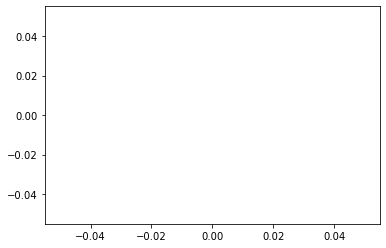

ValueError: With n_samples=1, test_size=0.8 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [18]:
predict_claims('0392ee82d61e6b95e117d22d8f732b12',39)

In [19]:
def predict_claims(uuid, week):
    data = unemployment_data[unemployment_data.uu_id == uuid].copy()
    data.loc[len(data.index)] = [uuid, week, data.total_claims.median(), 0,0,0,0,0,0,0,0]
    plt.plot(data.week_number, data.total_claims)
    plt.show()
    
    
    data
    
    X = data.drop(['uu_id','total_claims'], axis = 1)
    y = data[['total_claims']]
    
    
    
    # Splitting data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 101)
    # Train the Model

    regr = RandomForestRegressor(n_estimators = 10, max_depth = 10, random_state = 101)
    regr.fit(X_train, y_train.values.ravel())
    
    predictions = regr.predict(X_test)
    
    result = X_test
    result['total_claims'] = y_test
    result['prediction'] = predictions.tolist()
    
    x_axis = X_test.week_number
    
    plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
    plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')

    plt.xlabel('Week Number')
    plt.ylabel('Total Claims')
    plt.title('Tract: '+uuid)

    plt.grid(color = '#D3D3D3', linestyle = 'solid')

    plt.legend(loc = 'lower right')

    plt.show()
    
    
    return result.sort_values(by = 'week_number')

TypeError: float() argument must be a string or a number, not 'NAType'

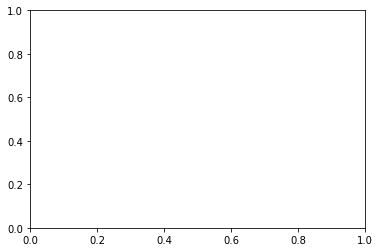

In [20]:
predict_claims('0392ee82d61e6b95e117d22d8f732b12',39)

In [21]:
def predict_claims(uuid, week):
    data = unemployment_data[unemployment_data.uu_id == uuid].copy()
    data.loc[len(data.index)] = [uuid, week, data.total_claims.median(), 0,0,0,0,0,0,0,0]
    plt.plot(data.week_number, data.total_claims)
    plt.show()
    
    
    data
    
    X = data.drop(['uu_id','total_claims'], axis = 1)
    y = data[['total_claims']]
    
    
    
    # Splitting data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 101)
    # Train the Model

    regr = RandomForestRegressor(n_estimators = 10, max_depth = 10, random_state = 101)
    regr.fit(X_train, y_train.values.ravel())
    
    predictions = regr.predict(X_test)
    
    result = X_test
    result['total_claims'] = y_test
    result['prediction'] = predictions.tolist()
    
    x_axis = X_test.week_number
    
    plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
    plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')

    plt.xlabel('Week Number')
    plt.ylabel('Total Claims')
    plt.title('Tract: '+uuid)

    plt.grid(color = '#D3D3D3', linestyle = 'solid')

    plt.legend(loc = 'lower right')

    plt.show()
    
    result = result.sort_values(by = 'week_number')
    
    return result.prediction.loc[-1]

TypeError: float() argument must be a string or a number, not 'NAType'

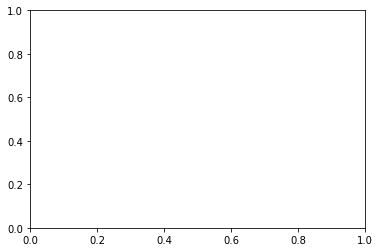

In [22]:
predict_claims('0392ee82d61e6b95e117d22d8f732b12',39)

In [23]:
def predict_claims(uuid, week):
    data = unemployment_data[unemployment_data.uu_id == uuid].copy()
    data.loc[len(data.index)] = [uuid, week, data.total_claims.median(), 0,0,0,0,0,0,0,0]
    plt.plot(data.week_number, data.total_claims)
    plt.show()
    
    
    data
    
    X = data.drop(['uu_id','total_claims'], axis = 1)
    y = data[['total_claims']]
    
    
    
    # Splitting data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 101)
    # Train the Model

    regr = RandomForestRegressor(n_estimators = 10, max_depth = 10, random_state = 101)
    regr.fit(X_train, y_train.values.ravel())
    
    predictions = regr.predict(X_test)
    
    result = X_test
    result['total_claims'] = y_test
    result['prediction'] = predictions.tolist()
    
    x_axis = X_test.week_number
    
    plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
    plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')

    plt.xlabel('Week Number')
    plt.ylabel('Total Claims')
    plt.title('Tract: '+uuid)

    plt.grid(color = '#D3D3D3', linestyle = 'solid')

    plt.legend(loc = 'lower right')

    plt.show()
    
    result = result.sort_values(by = 'week_number')
    
    return result.prediction.iloc[-1]

TypeError: float() argument must be a string or a number, not 'NAType'

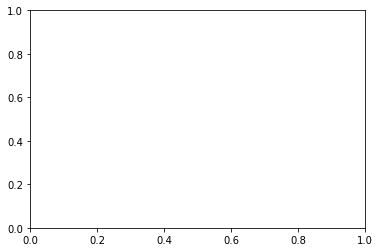

In [24]:
predict_claims('0392ee82d61e6b95e117d22d8f732b12',39)

In [25]:
def predict_claims(uuid, week):
    data = unemployment_data[unemployment_data.uu_id == uuid].copy()
    data.loc[len(data.index)] = [uuid, week, data.total_claims.median(), 0,0,0,0,0,0,0,0]
    plt.plot(data.week_number, data.total_claims)
    plt.show()
    
    
    data
    
    X = data.drop(['uu_id','total_claims'], axis = 1)
    y = data[['total_claims']]
    
    
    
    # Splitting data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 101)
    # Train the Model

    regr = RandomForestRegressor(n_estimators = 10, max_depth = 10, random_state = 101)
    regr.fit(X_train, y_train.values.ravel())
    
    predictions = regr.predict(X_test)
    
    result = X_test
    result['total_claims'] = y_test
    result['prediction'] = predictions.tolist()
    
    x_axis = X_test.week_number
    
    plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
    plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')

    plt.xlabel('Week Number')
    plt.ylabel('Total Claims')
    plt.title('Tract: '+uuid)

    plt.grid(color = '#D3D3D3', linestyle = 'solid')

    plt.legend(loc = 'lower right')

    plt.show()
    
    result = result.sort_values(by = 'week_number')
    
    return result.prediction.iloc[-1].round()

TypeError: float() argument must be a string or a number, not 'NAType'

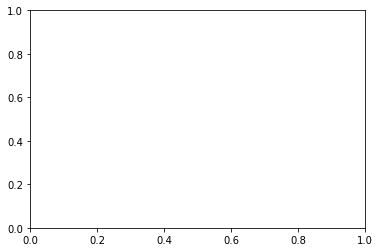

In [26]:
predict_claims('0392ee82d61e6b95e117d22d8f732b12',39)

In [27]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [28]:
query_job = bigquery_client.query(query)
prediction_list = query_job.to_dataframe()

In [29]:
prediction_list

uu_id  week_number
0    5bf51fc2e162d6faf9e3cf79e4198378           44
1    420b44cc7e3f55d738df565421e59941           44
2    e39c66ecceec76ee8f9f811fa4a2d246           44
3    a90462cd11ae4e43144239bf7c4828a4           44
4    8b20a6749088c7ff1237983076ebfeaa           44
..                                ...          ...
520  46c4f6c75e663b1ca82ea7994e6d83d3           44
521  1deebda501712e7595b531b8337bc31a           44
522  5a9758f65f001b6432ff31ff64a459d7           44
523  e8b3b95e93a6dc7dbb90f4e72e7ac065           44
524  932a58530abff8a48558e2a15639d453           44

[525 rows x 2 columns]

In [30]:
uuids = prediction_list.tolist()

AttributeError: 'DataFrame' object has no attribute 'tolist'

In [31]:
uuids = prediction_list.uu_id.tolist()

In [32]:
len(uuids)

525

In [33]:
import csv 

In [34]:
fields = ['uu_id', 'week_number', 'total_claims']
rows = []
for uuid in uuids:
    rows.append(list(uuid, 39, predict_claims(uuid, 39))

SyntaxError: unexpected EOF while parsing (2404139596.py, line 4)

In [35]:
filename = 'submission_prediction_output.csv'

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


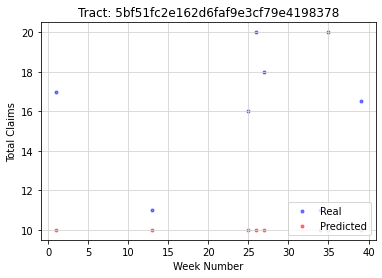

TypeError: list expected at most 1 argument, got 3

In [36]:
fields = ['uu_id', 'week_number', 'total_claims']
rows = []
for uuid in uuids:
    rows.append(list(uuid, 39, predict_claims(uuid, 39)))

In [37]:
filename = 'submission_prediction_output.csv'

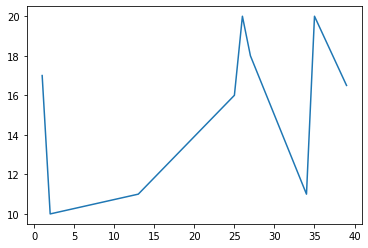

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


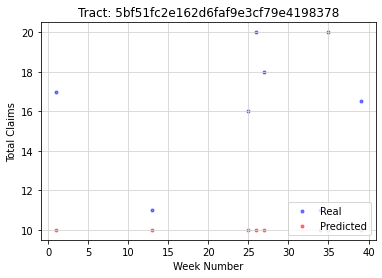

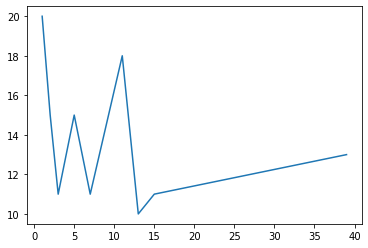

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


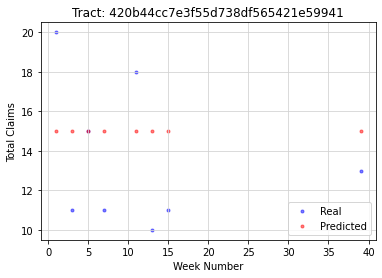

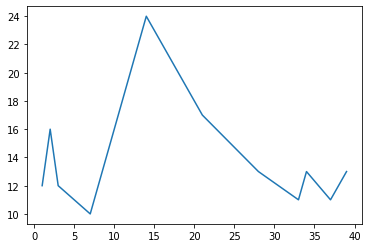

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


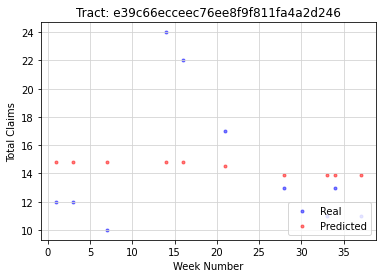

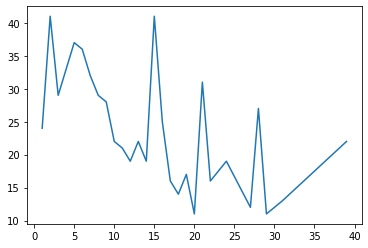

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


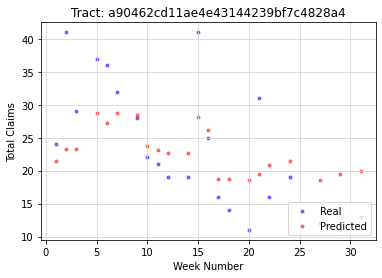

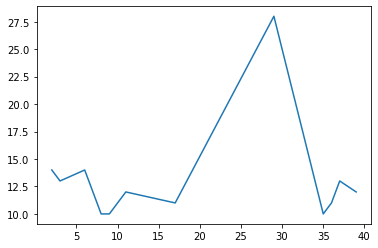

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


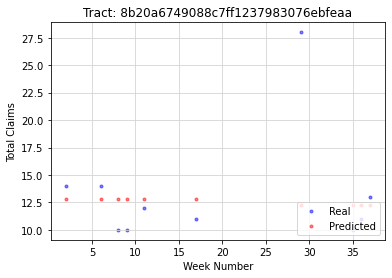

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


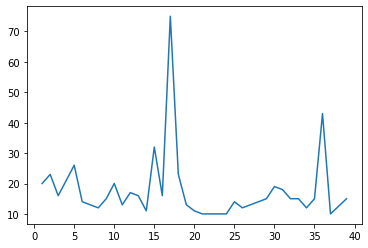

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


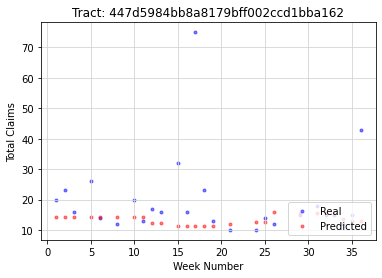

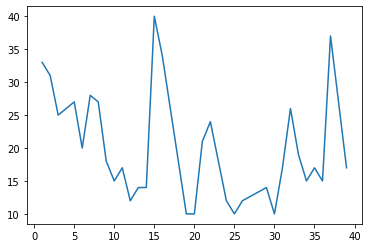

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


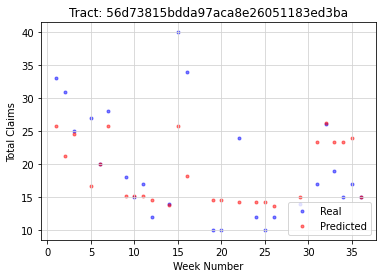

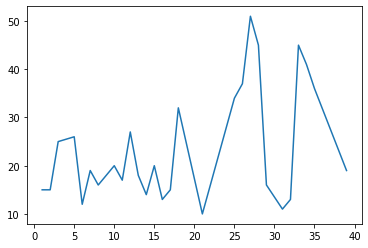

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


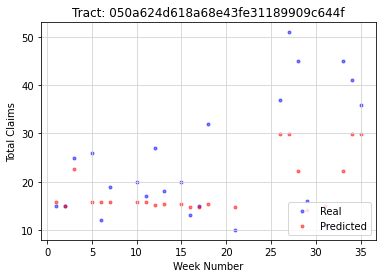

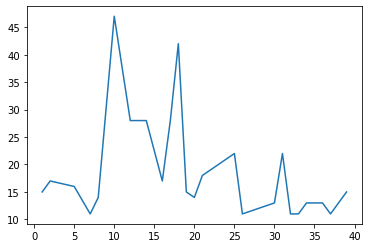

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


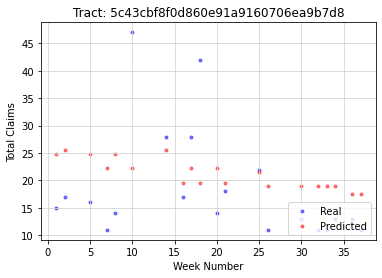

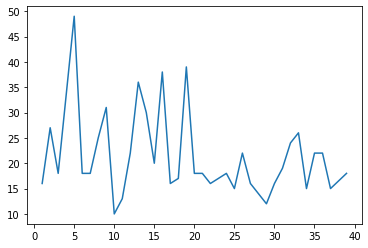

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


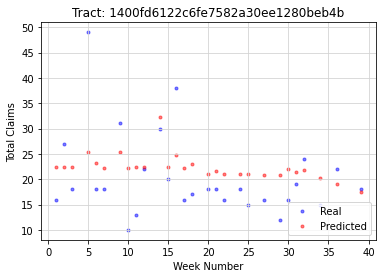

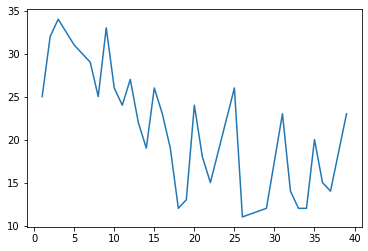

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


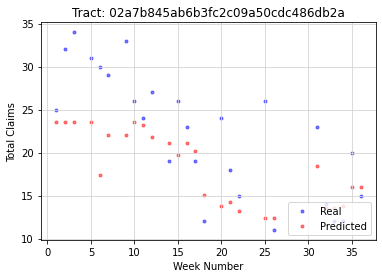

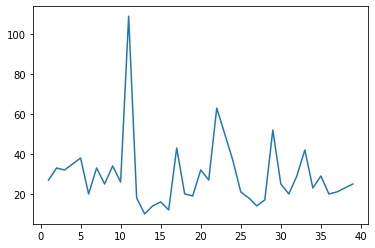

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


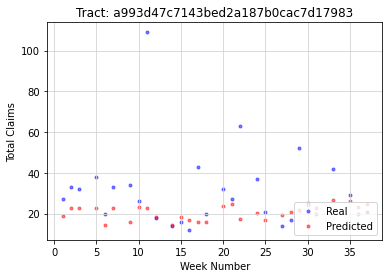

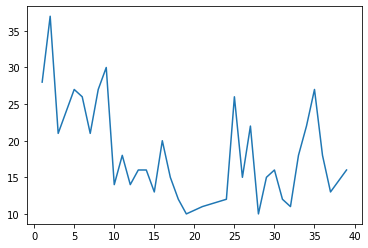

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


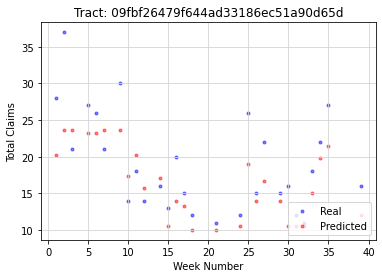

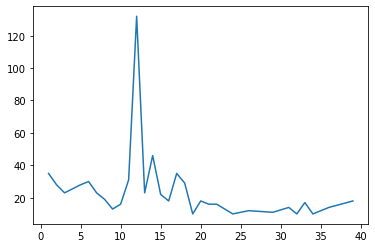

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


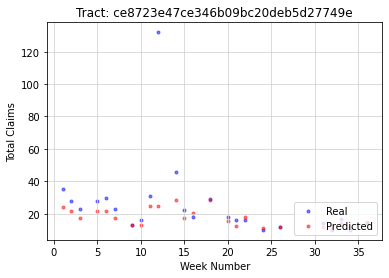

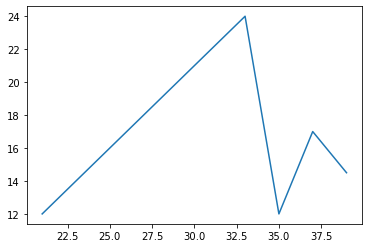

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


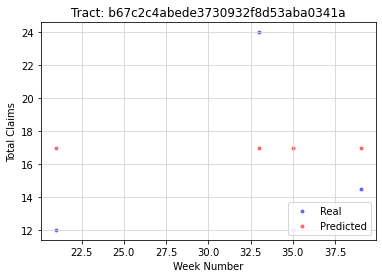

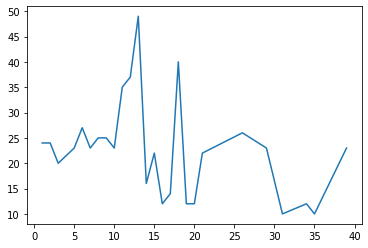

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


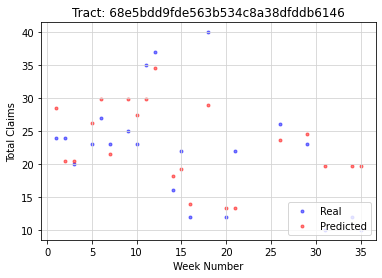

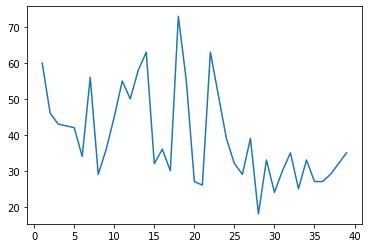

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


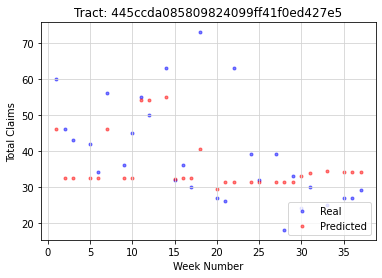

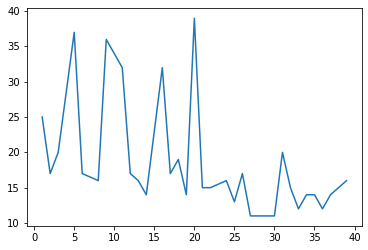

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


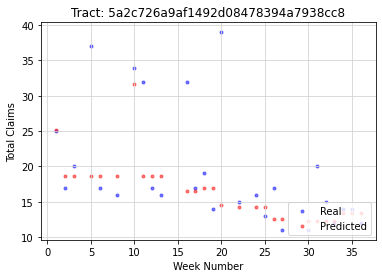

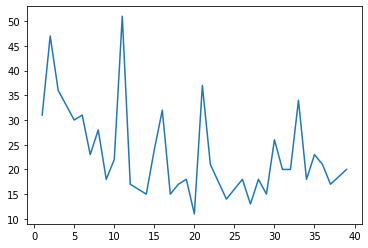

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


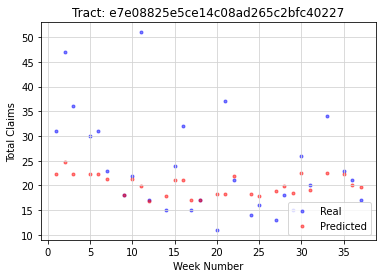

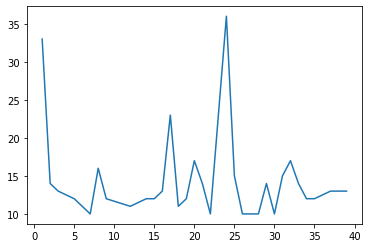

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


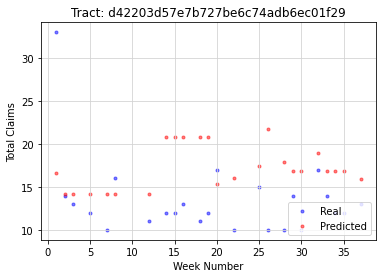

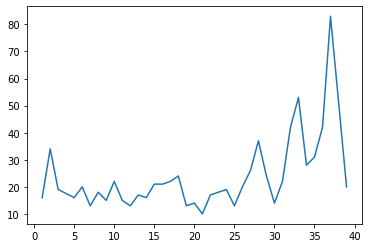

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


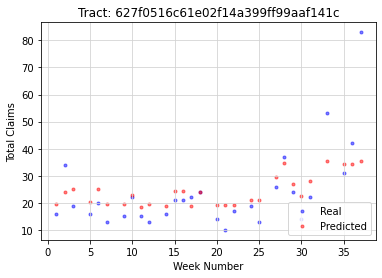

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


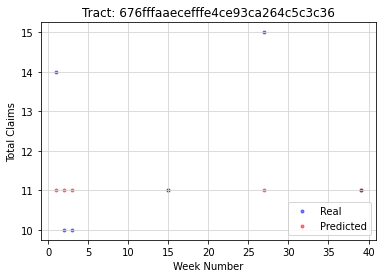

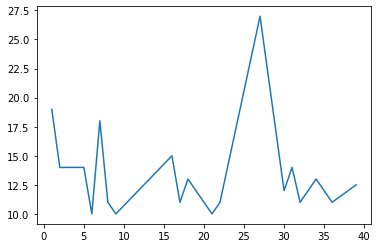

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


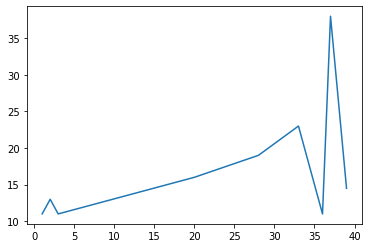

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


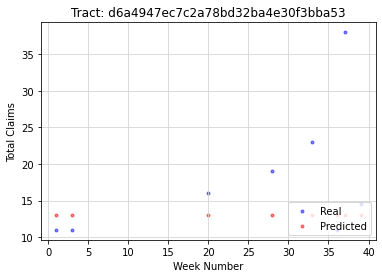

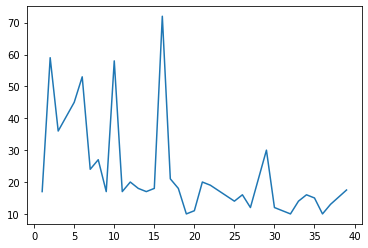

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


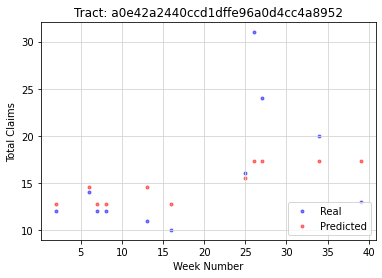

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


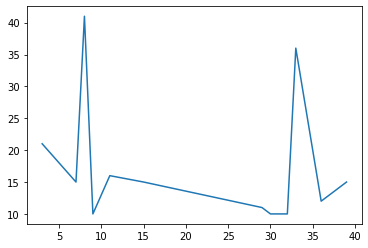

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


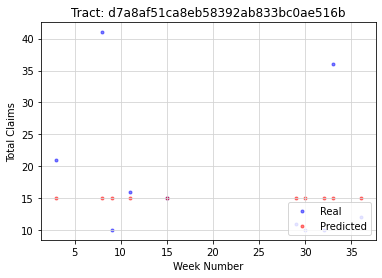

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


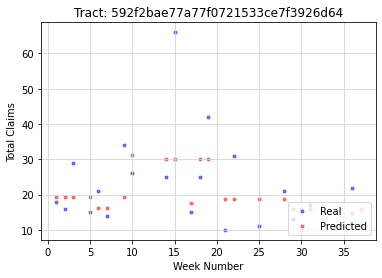

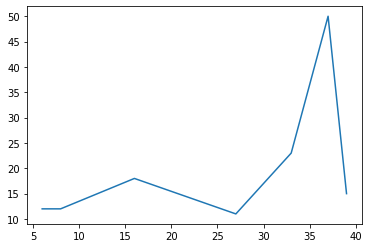

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


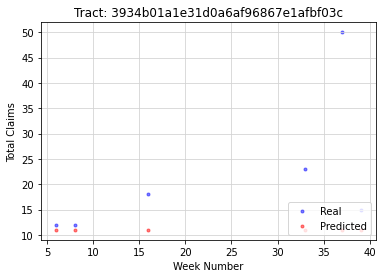

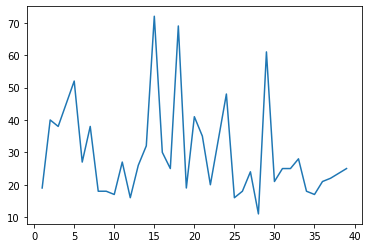

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


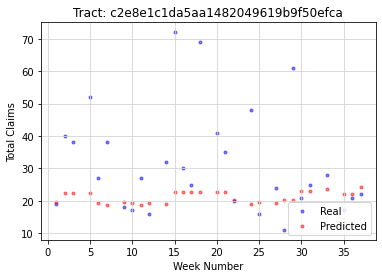

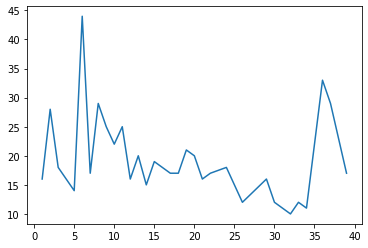

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


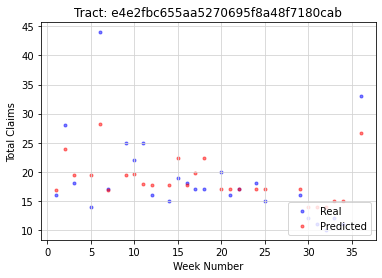

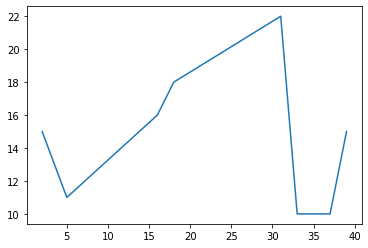

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


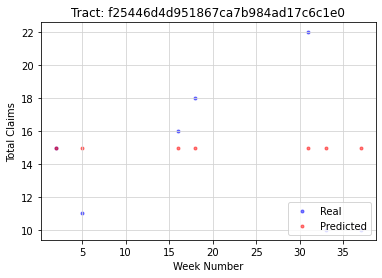

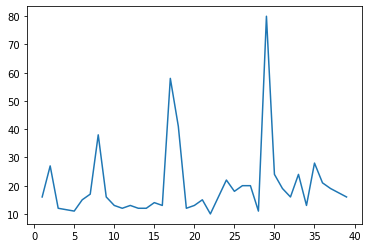

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


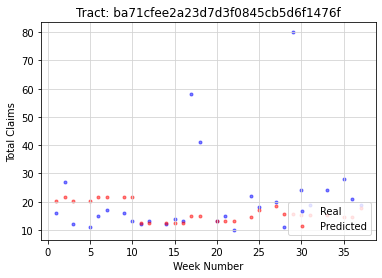

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


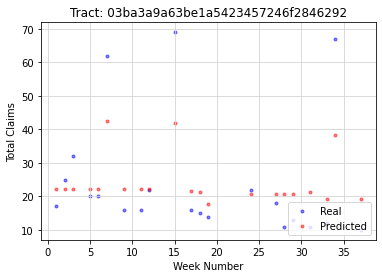

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


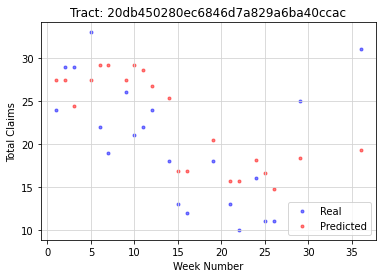

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


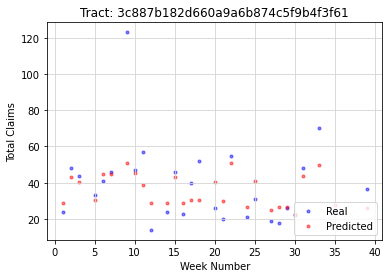

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


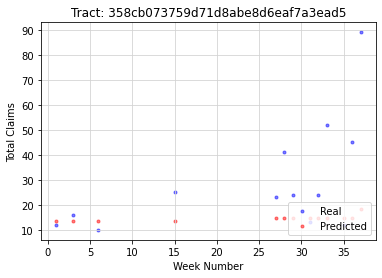

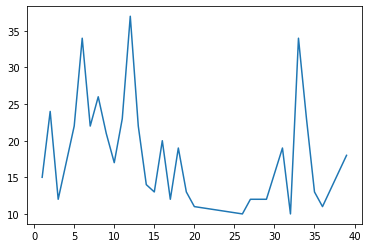

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


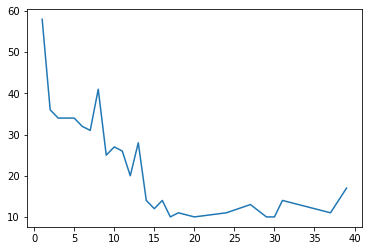

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


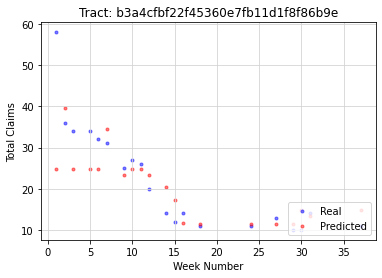

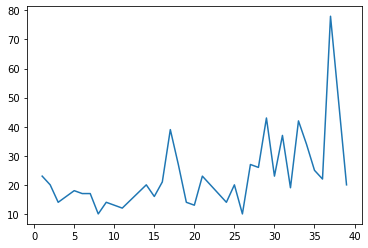

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


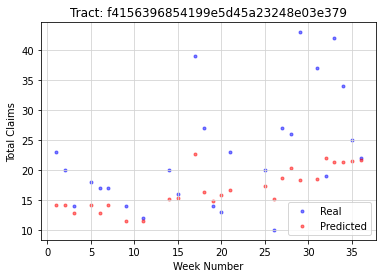

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


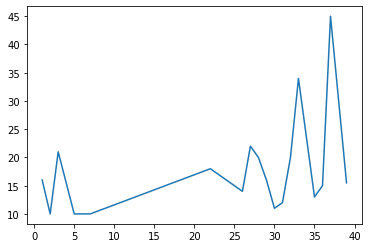

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


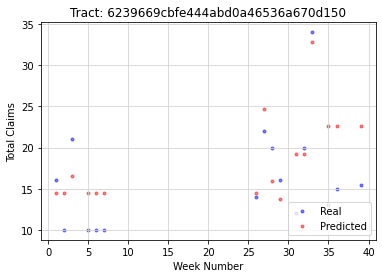

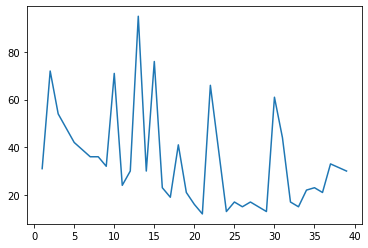

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


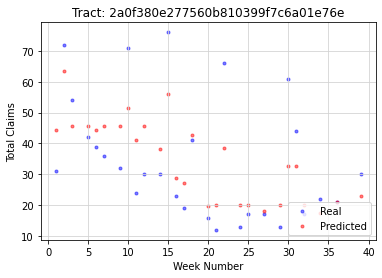

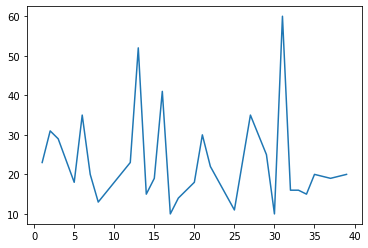

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


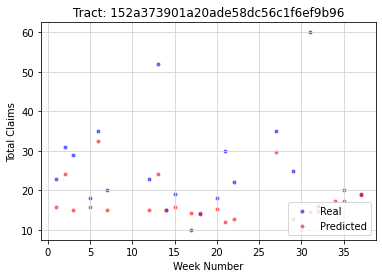

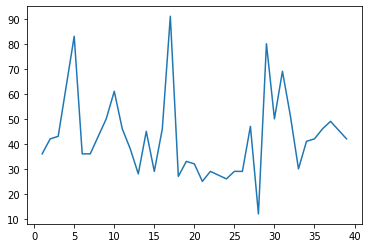

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


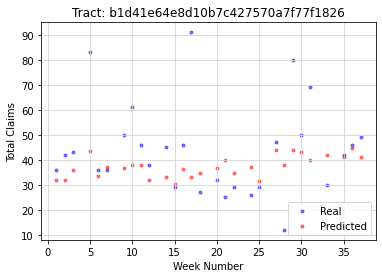

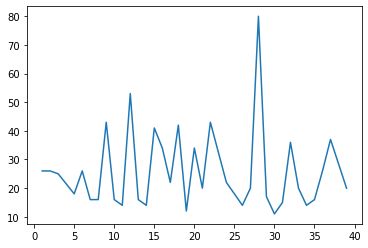

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


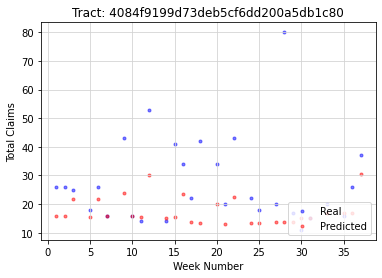

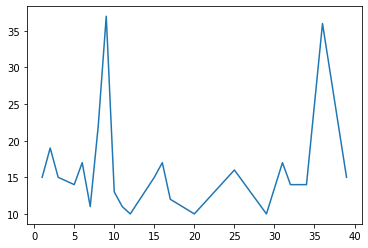

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


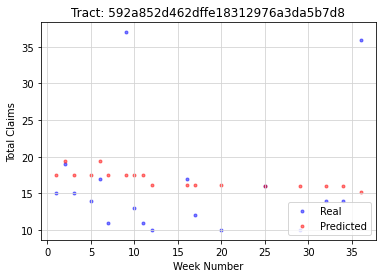

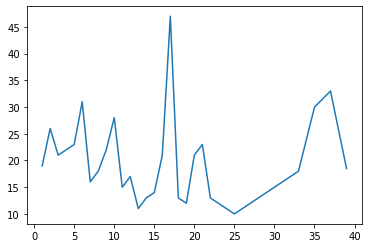

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


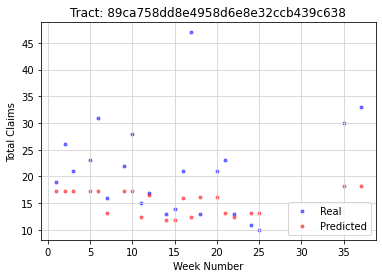

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


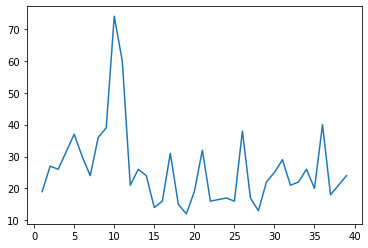

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


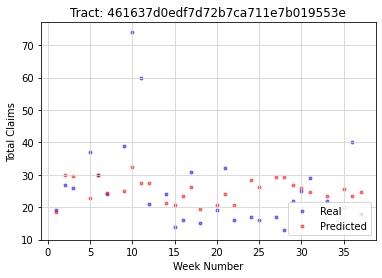

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


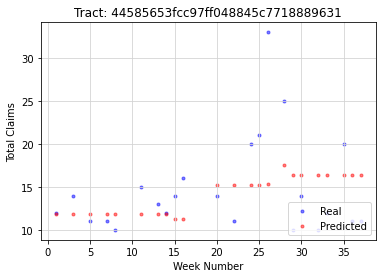

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


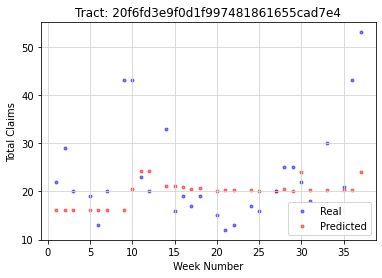

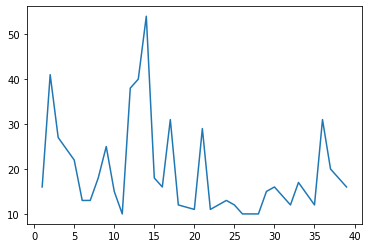

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


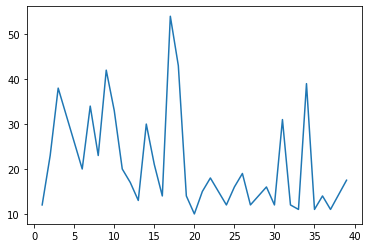

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


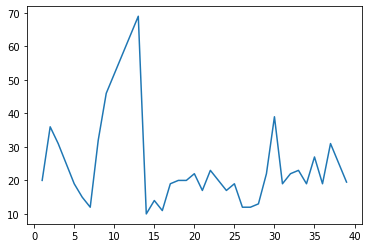

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


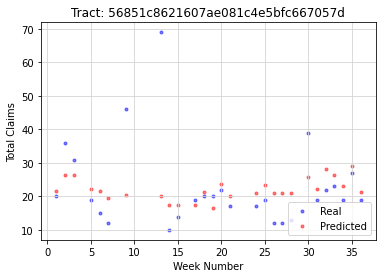

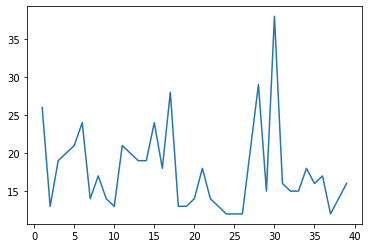

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


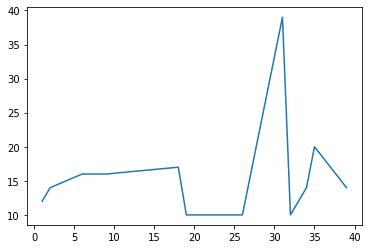

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


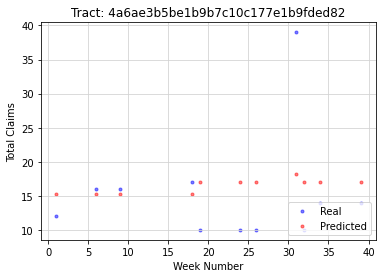

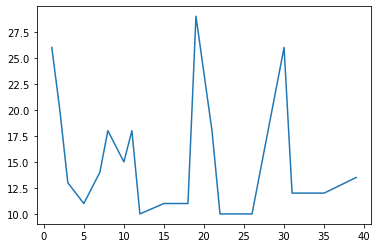

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


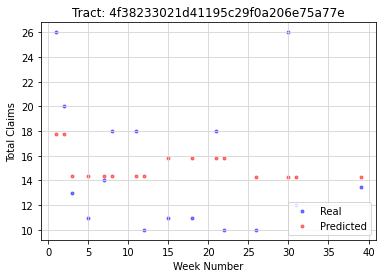

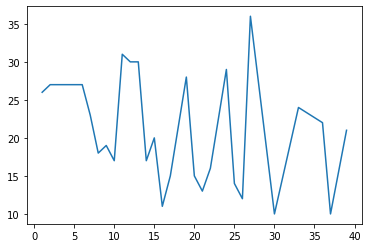

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


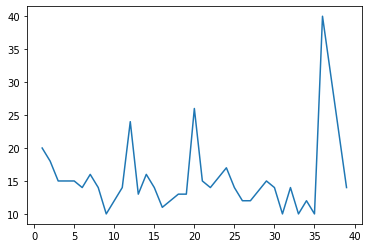

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


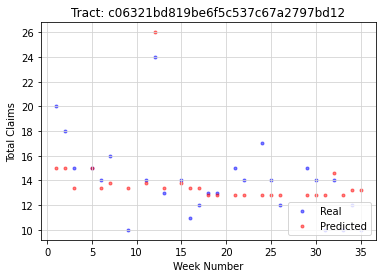

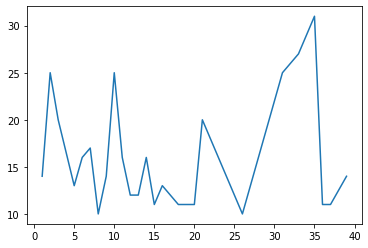

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


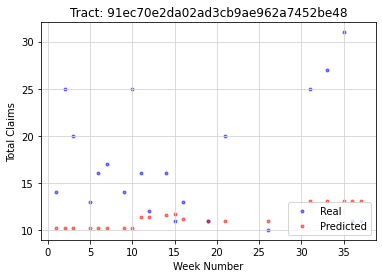

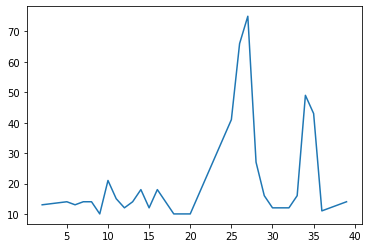

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


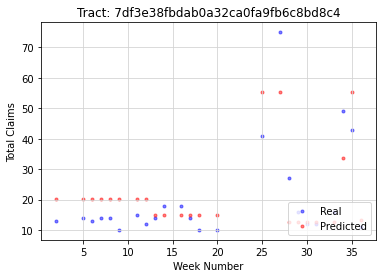

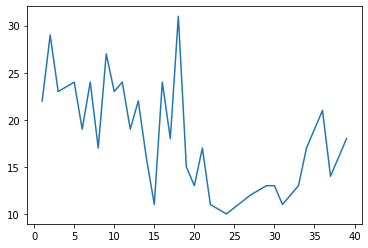

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


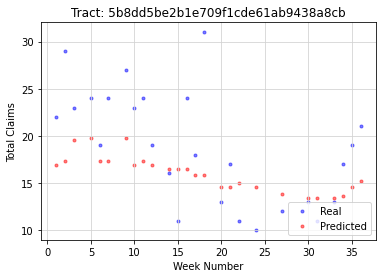

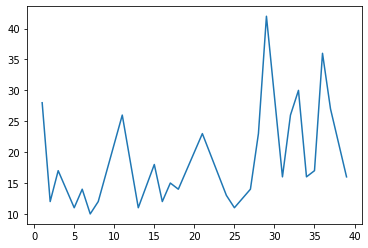

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


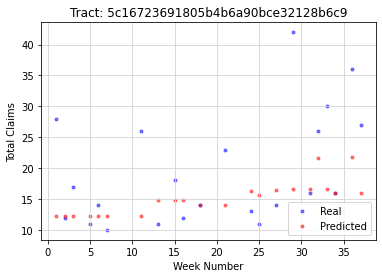

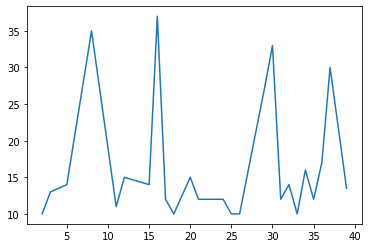

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


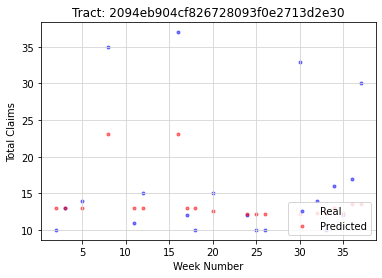

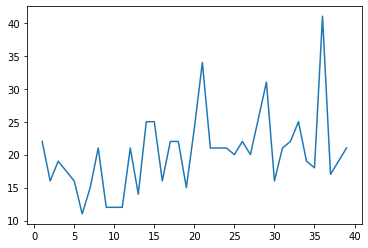

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


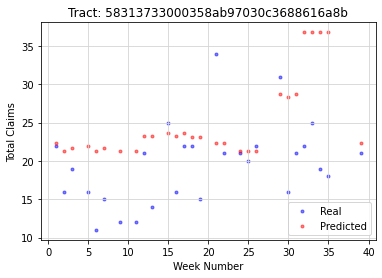

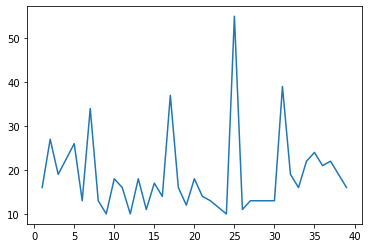

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


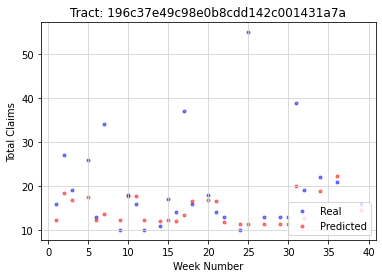

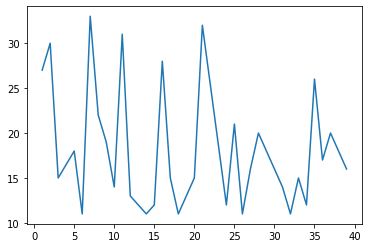

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


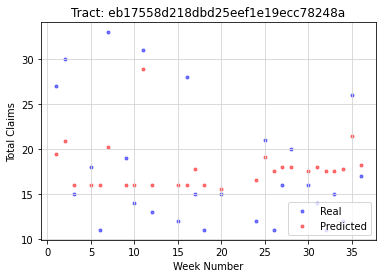

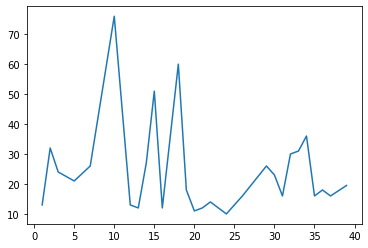

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


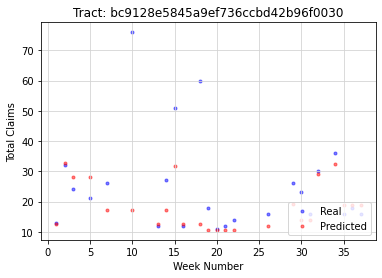

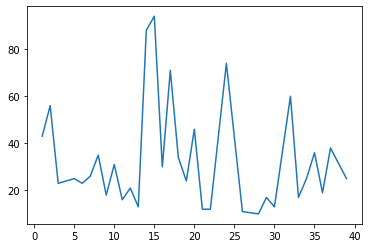

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


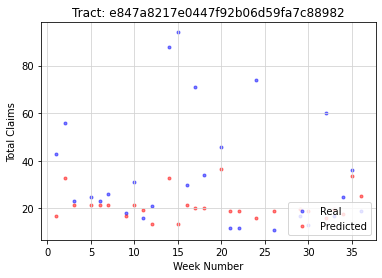

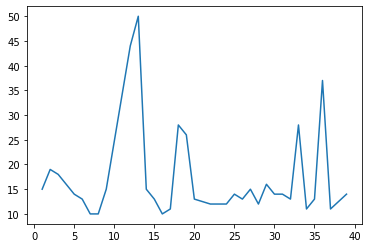

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


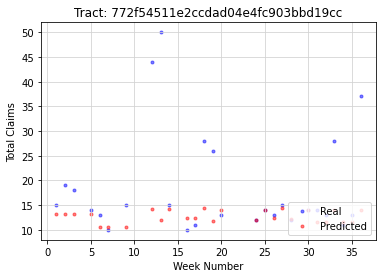

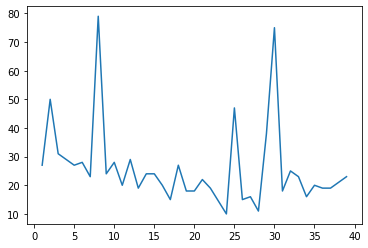

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


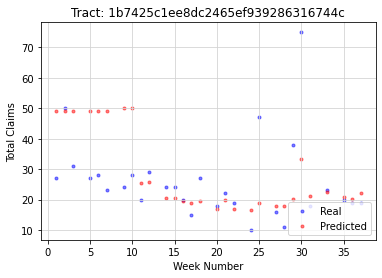

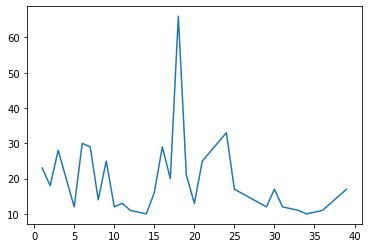

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


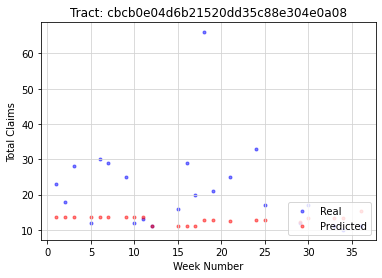

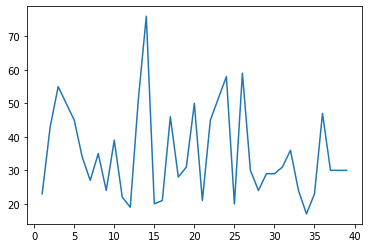

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


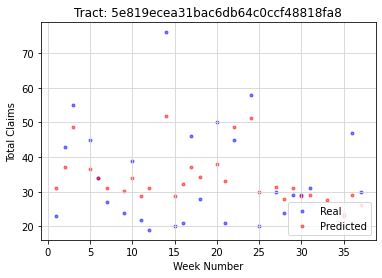

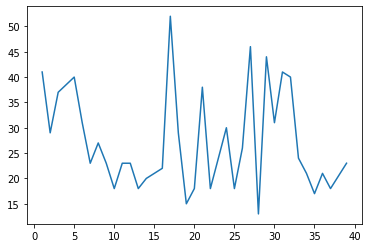

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


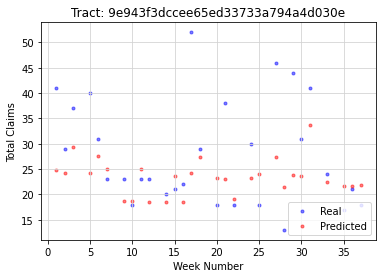

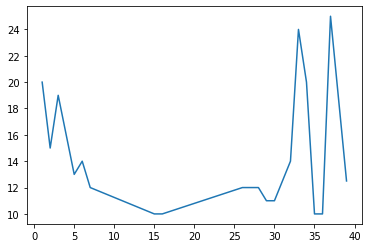

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


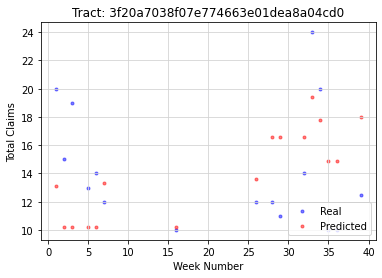

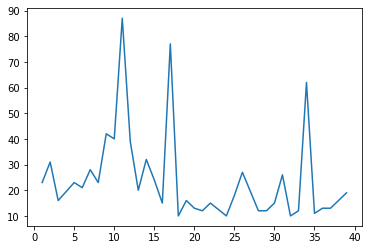

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


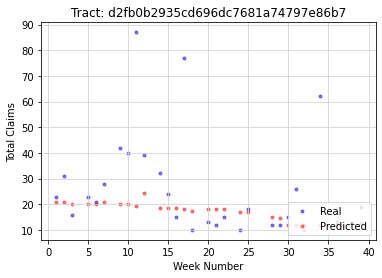

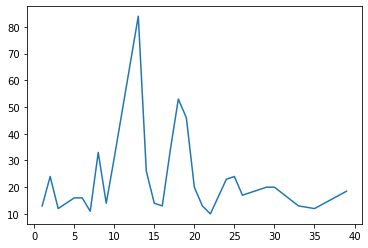

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


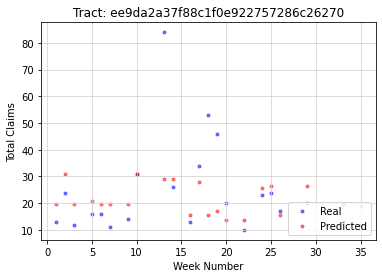

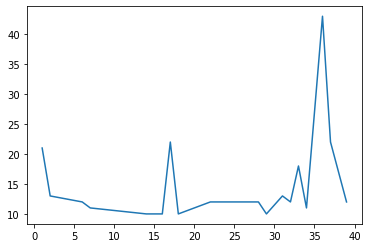

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


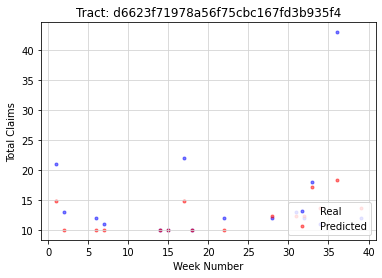

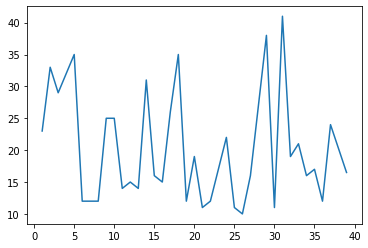

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


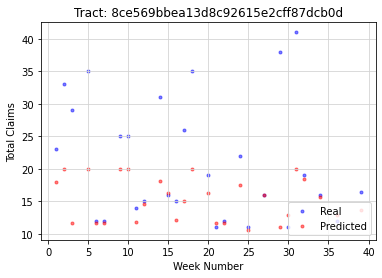

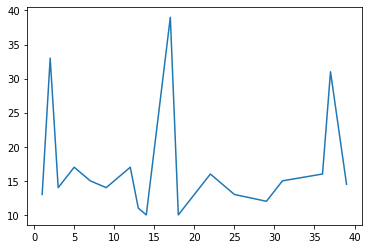

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


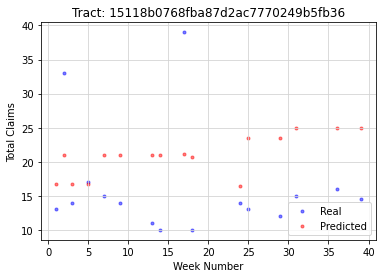

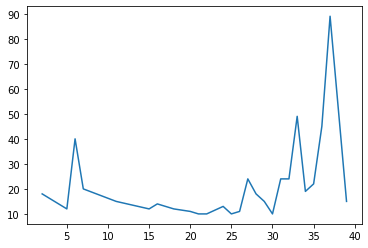

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


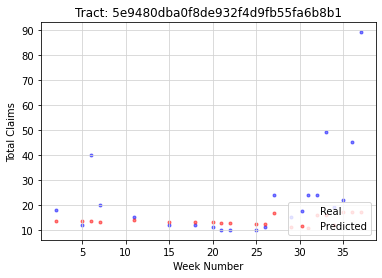

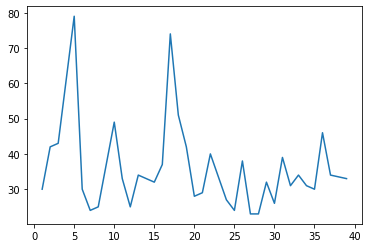

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


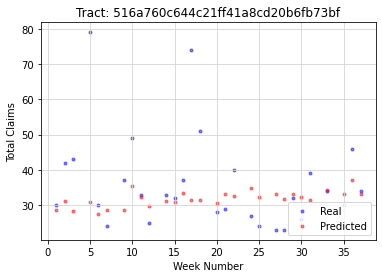

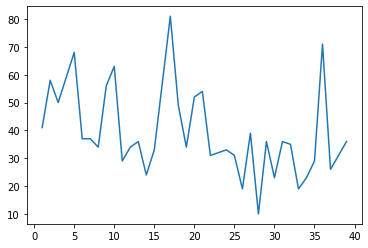

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


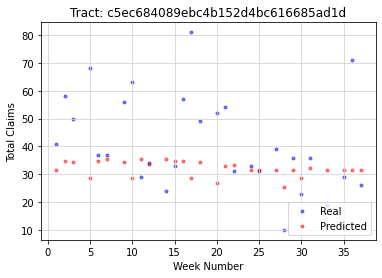

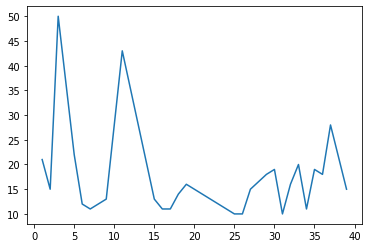

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


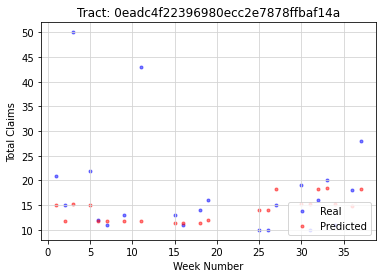

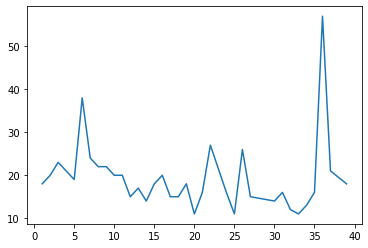

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


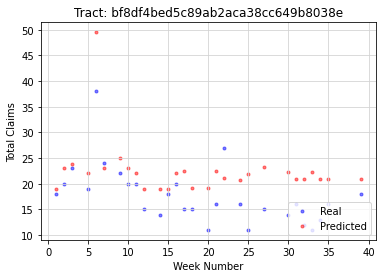

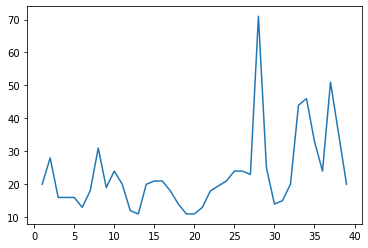

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


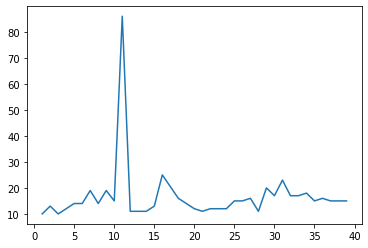

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


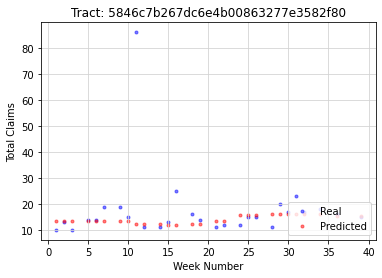

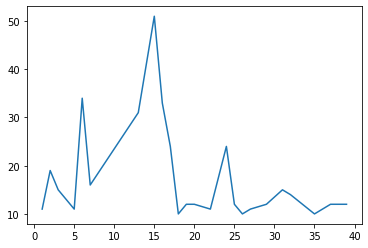

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


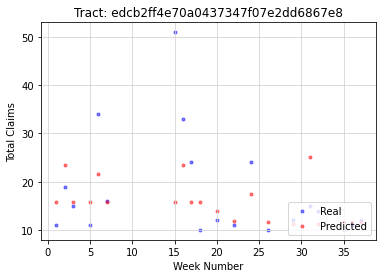

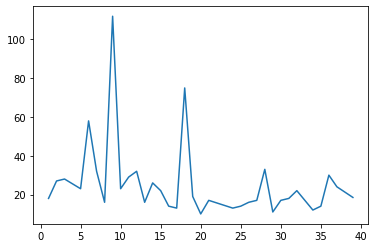

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


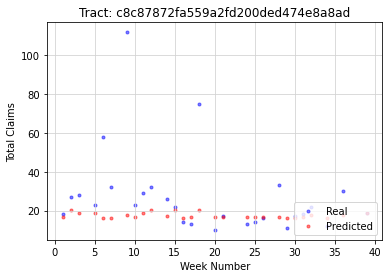

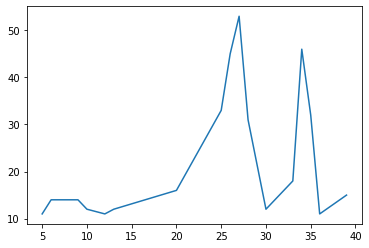

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


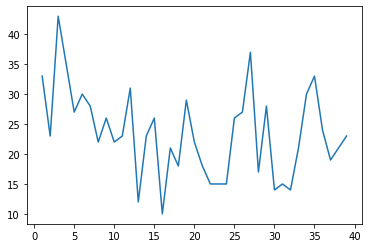

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


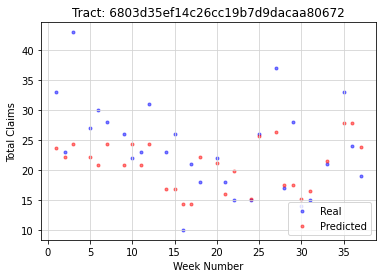

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


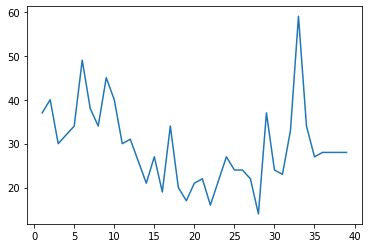

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


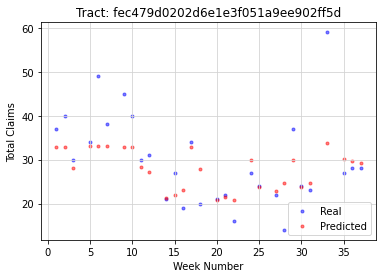

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


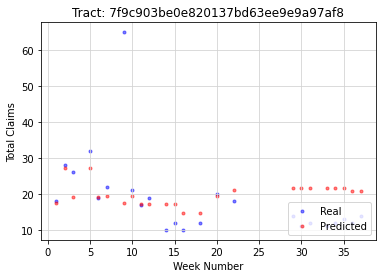

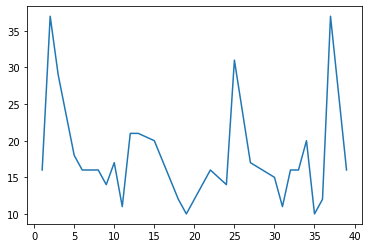

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


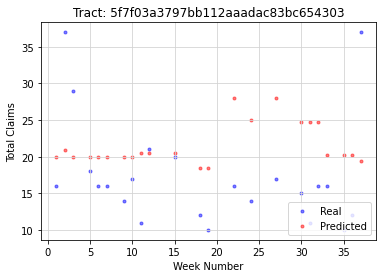

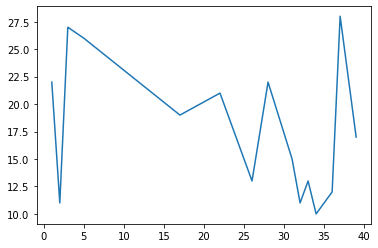

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


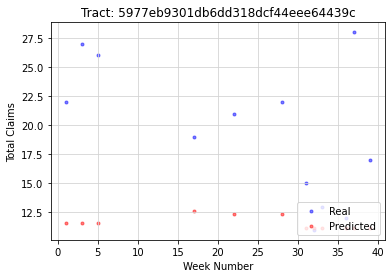

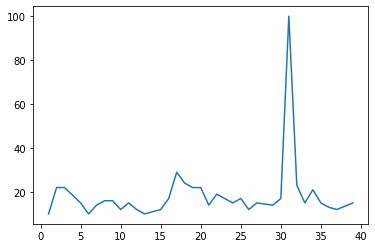

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


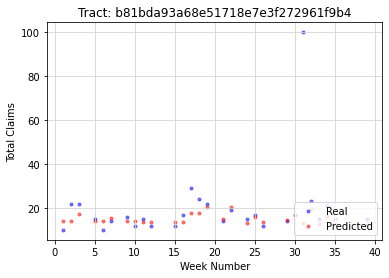

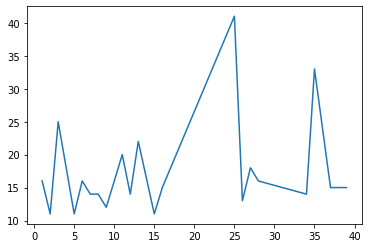

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


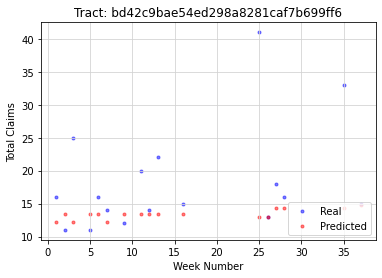

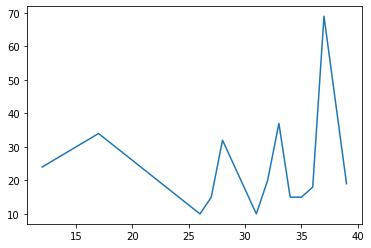

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


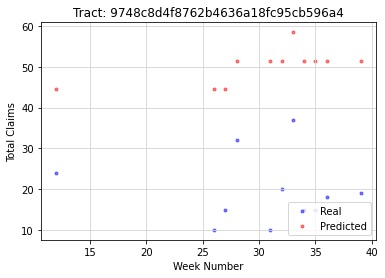

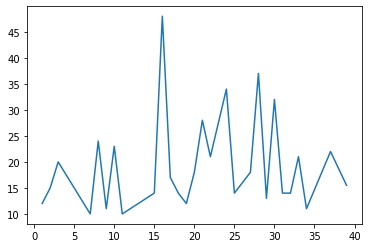

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


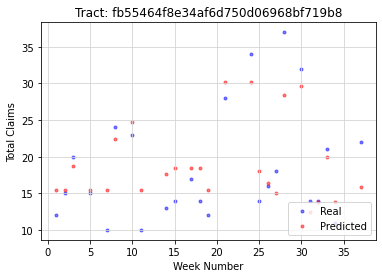

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


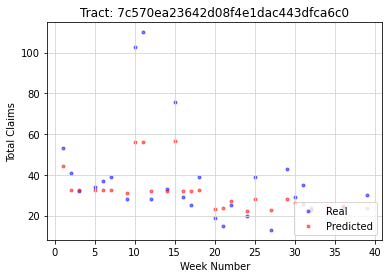

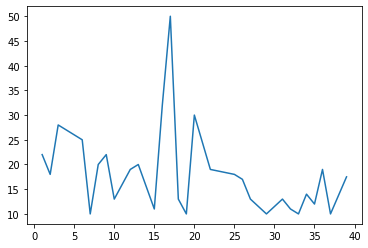

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


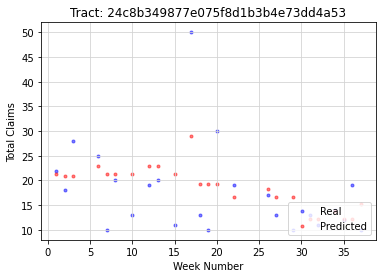

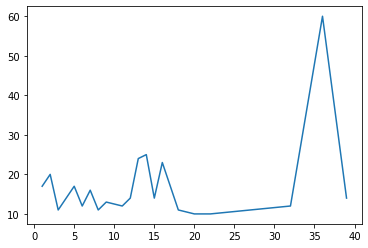

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


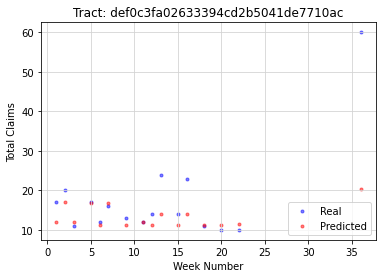

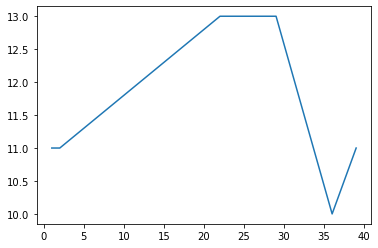

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


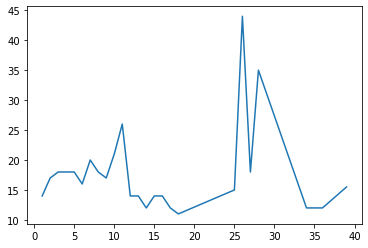

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


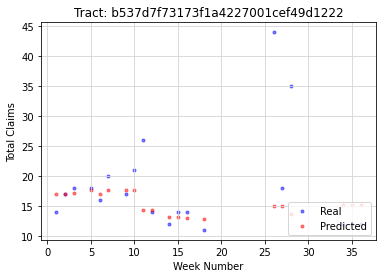

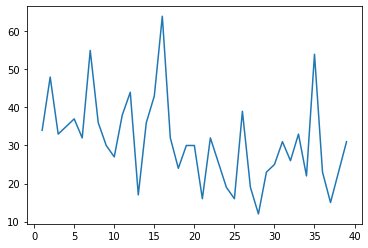

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


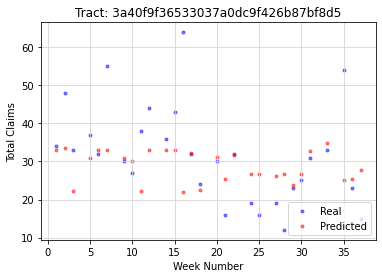

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


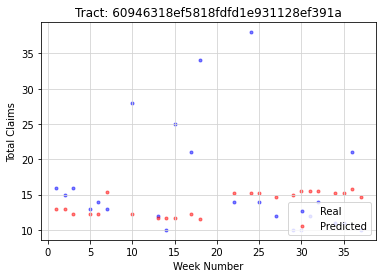

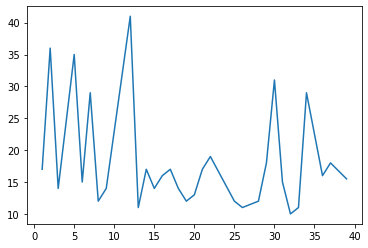

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


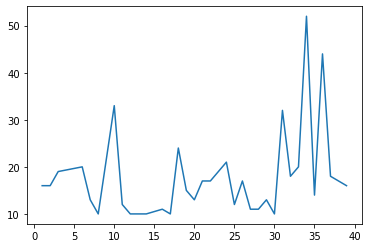

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


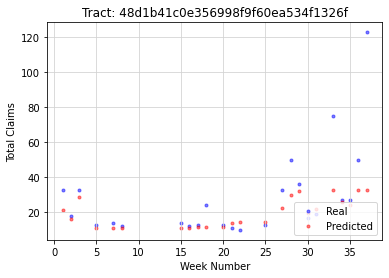

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


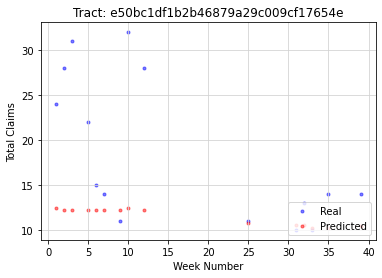

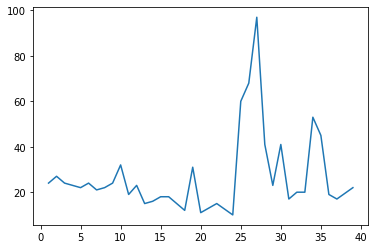

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


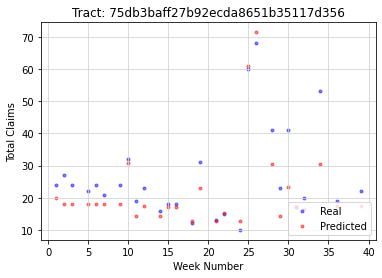

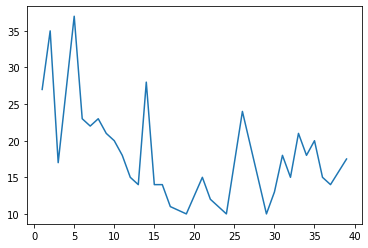

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


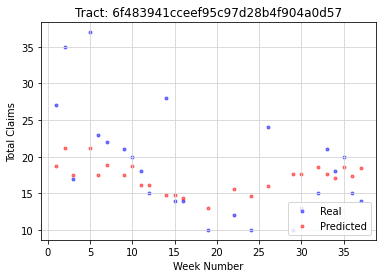

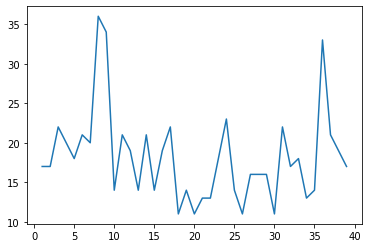

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


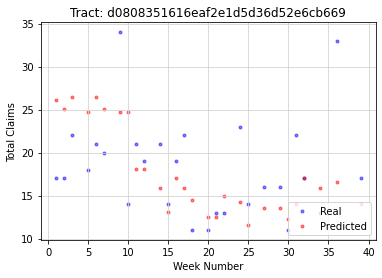

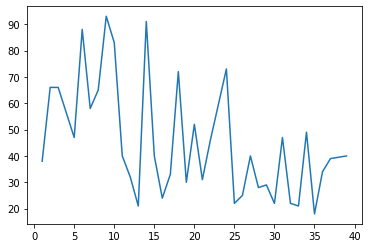

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


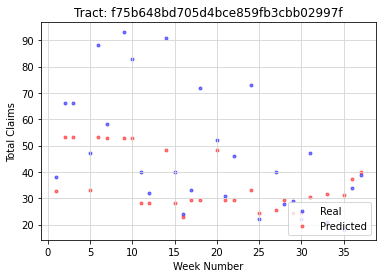

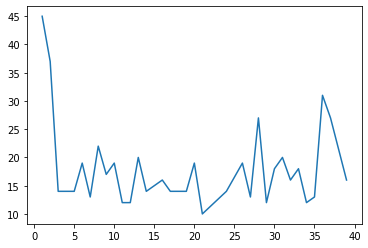

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


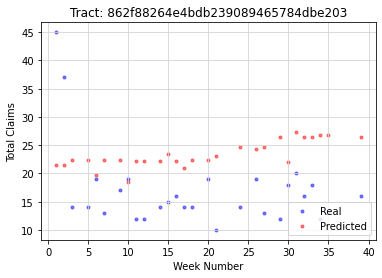

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


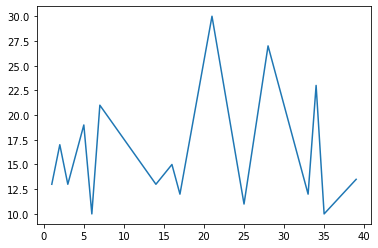

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


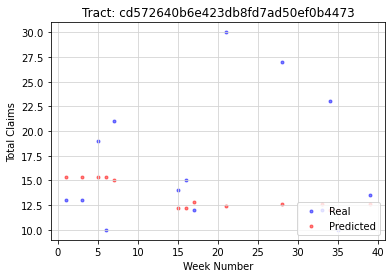

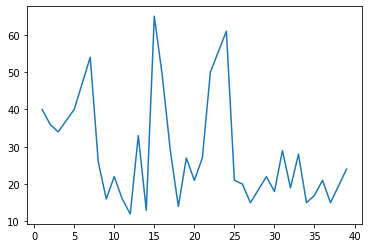

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


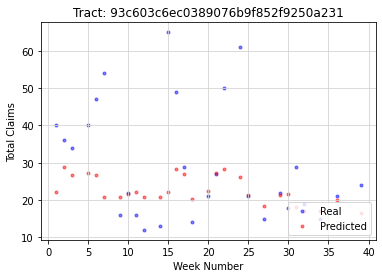

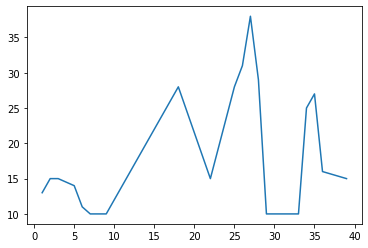

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


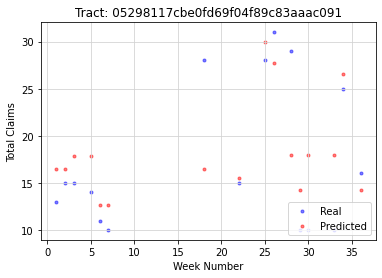

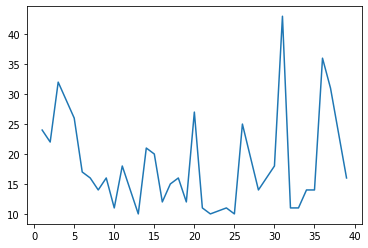

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


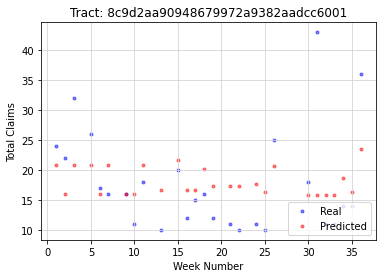

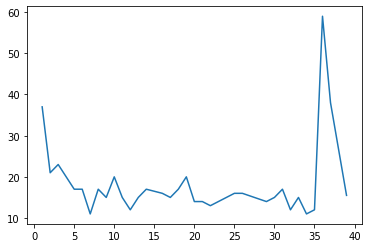

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


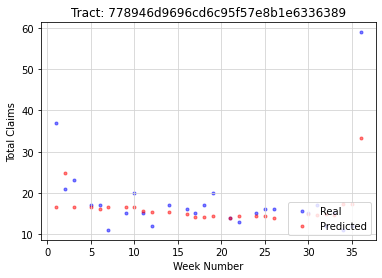

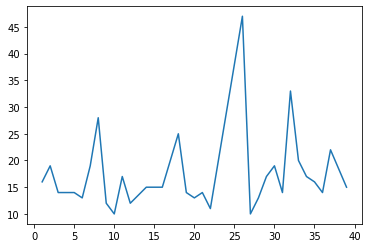

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


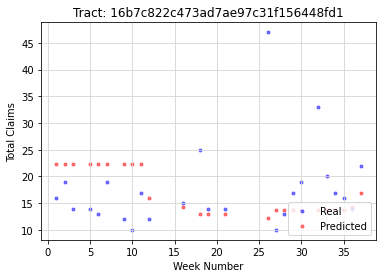

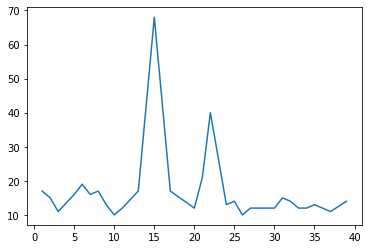

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


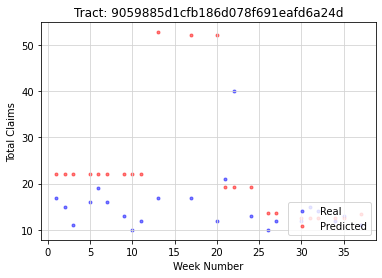

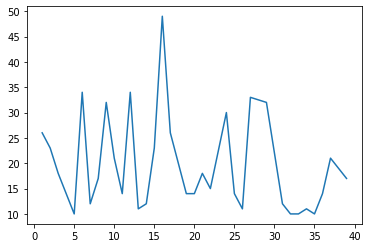

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


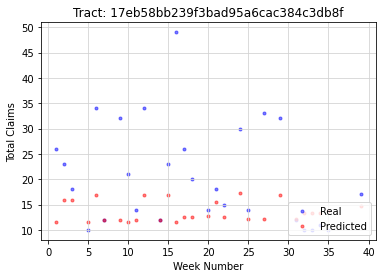

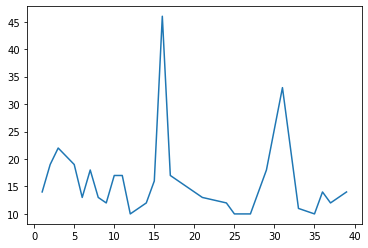

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


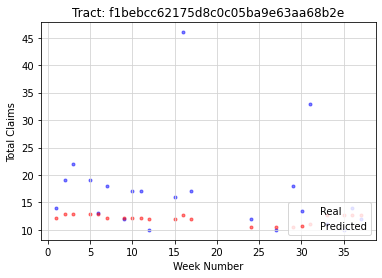

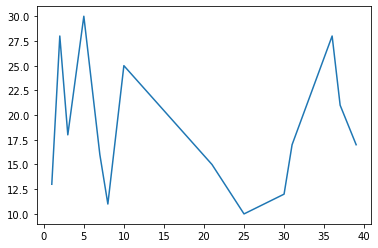

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


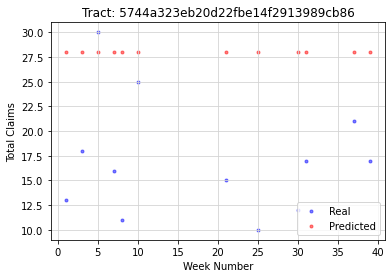

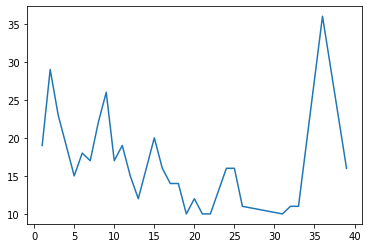

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


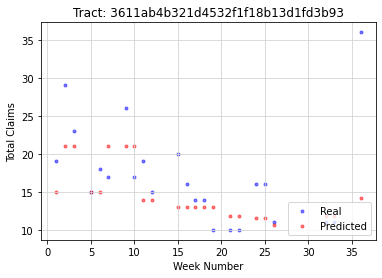

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


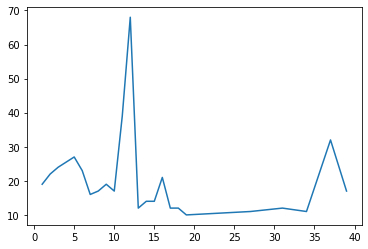

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


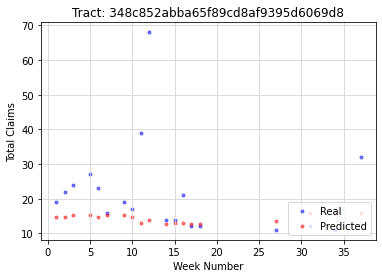

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


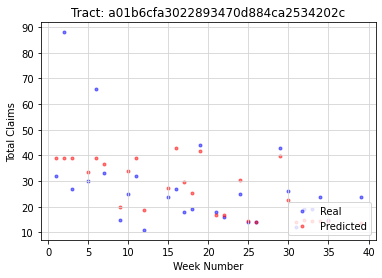

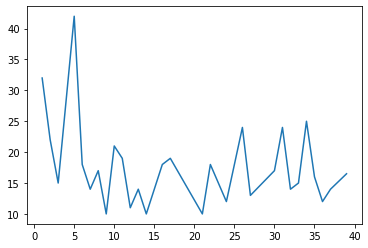

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


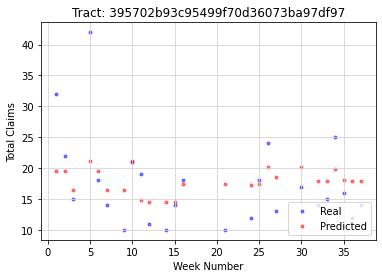

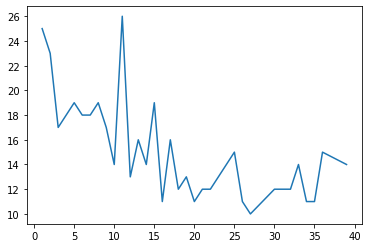

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


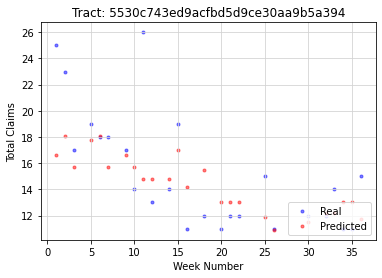

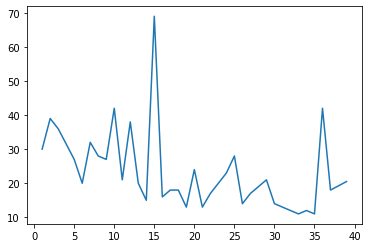

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


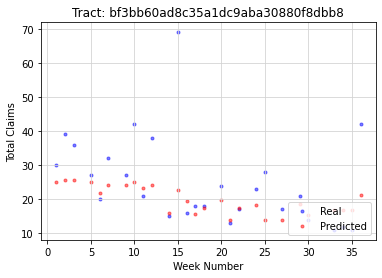

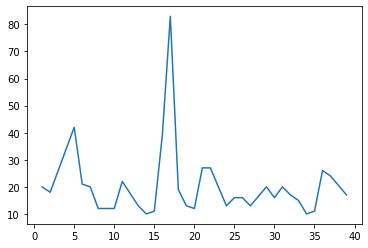

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


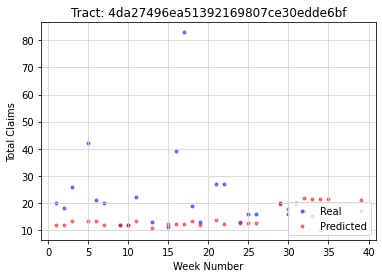

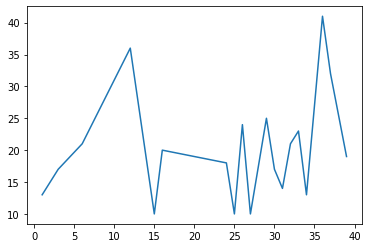

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


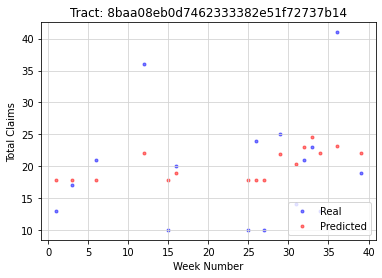

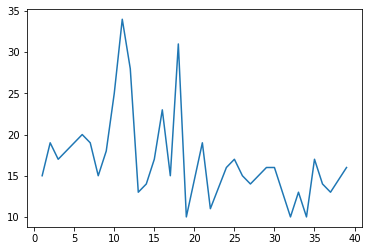

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


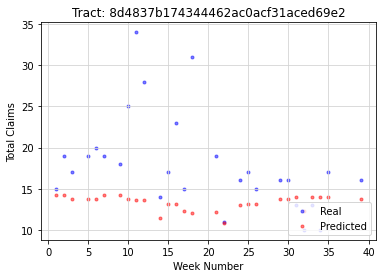

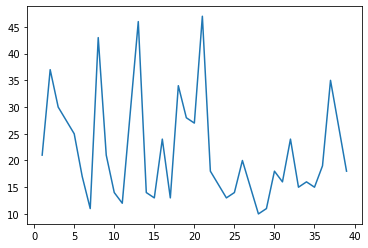

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


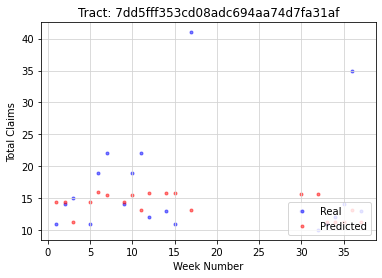

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


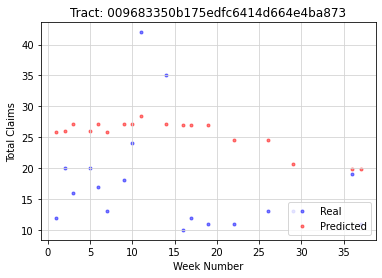

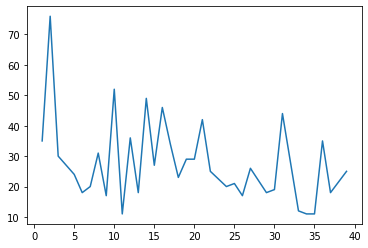

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


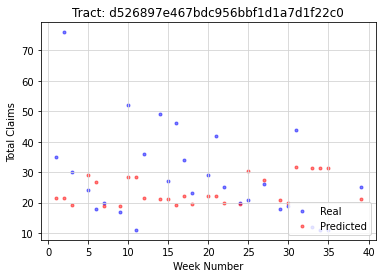

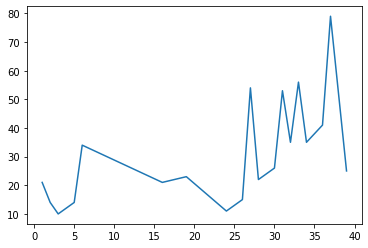

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


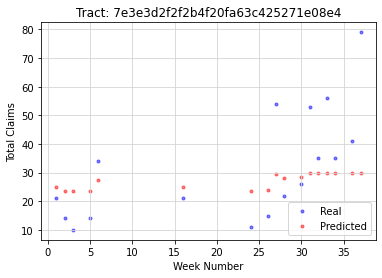

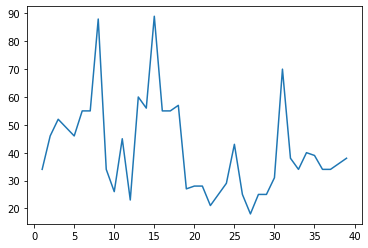

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


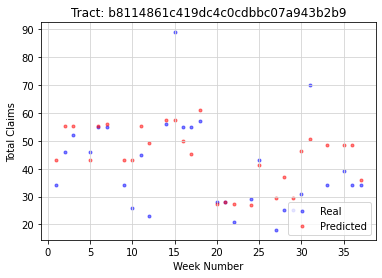

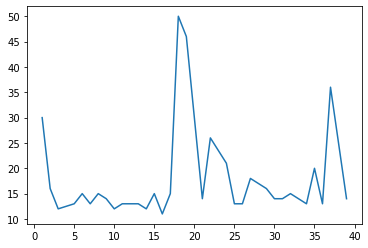

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


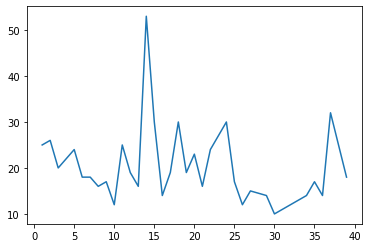

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


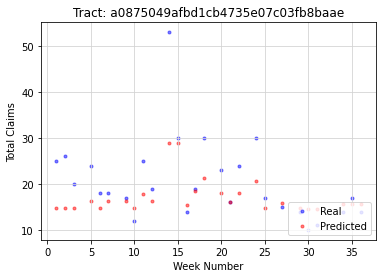

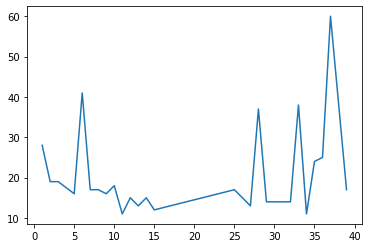

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


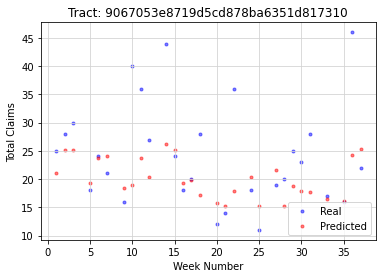

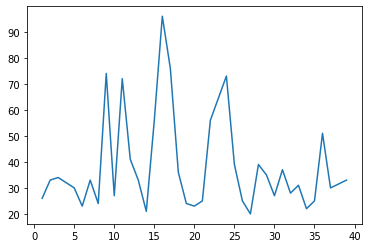

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


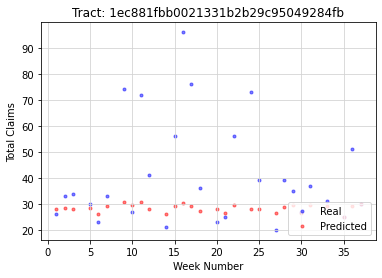

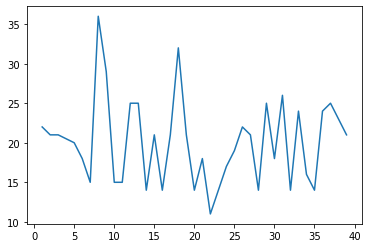

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


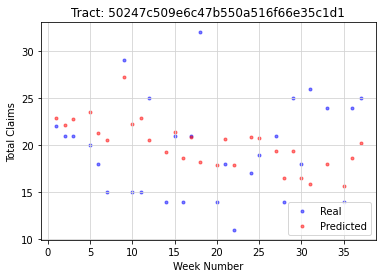

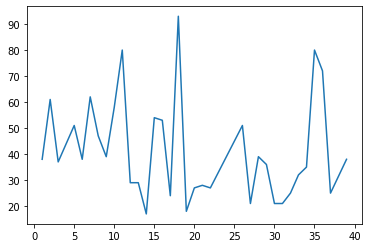

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


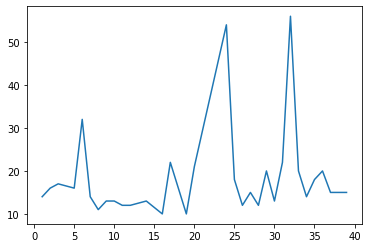

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


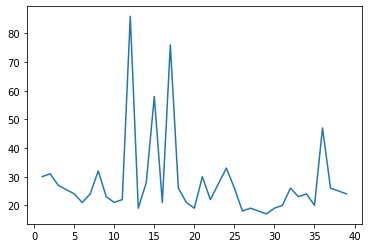

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


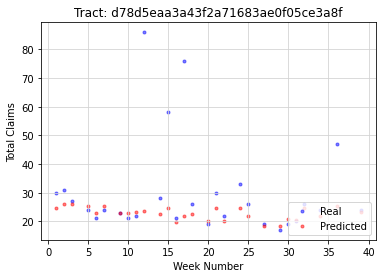

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


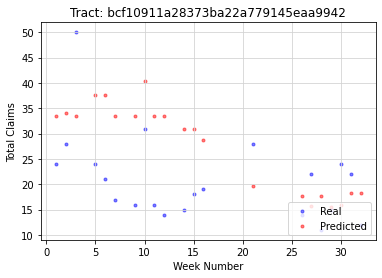

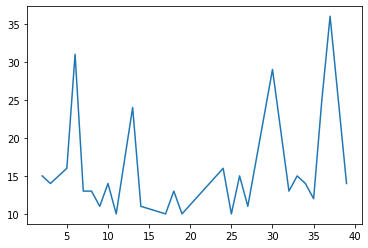

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


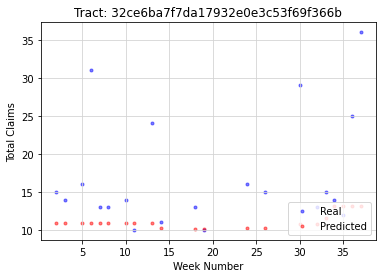

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


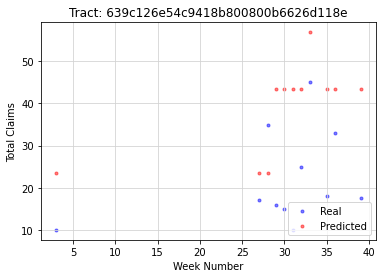

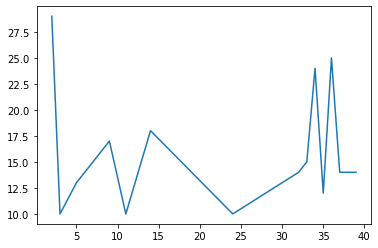

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


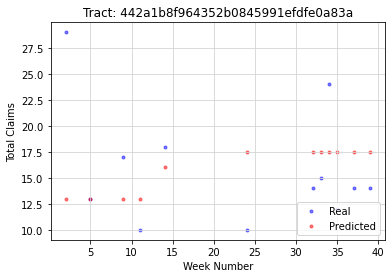

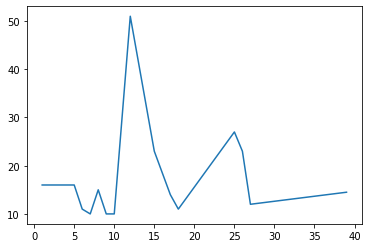

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


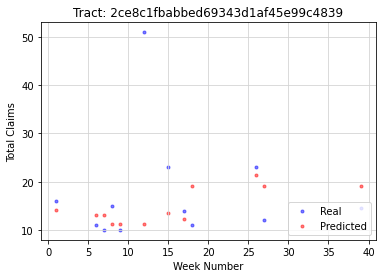

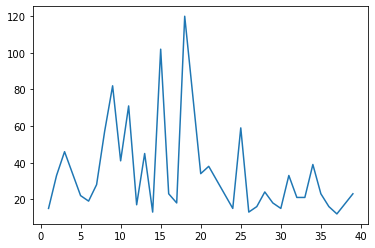

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


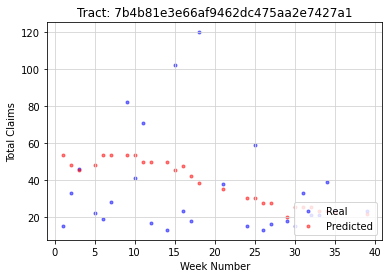

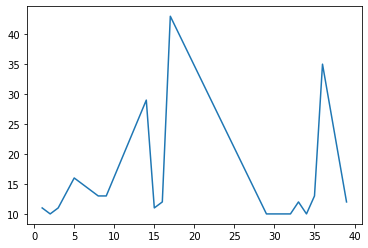

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


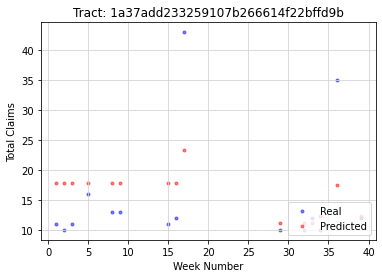

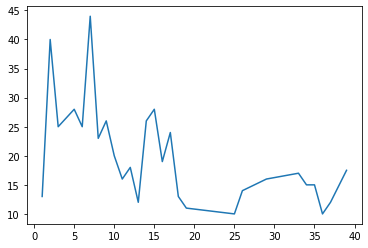

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


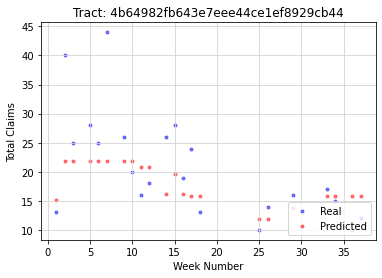

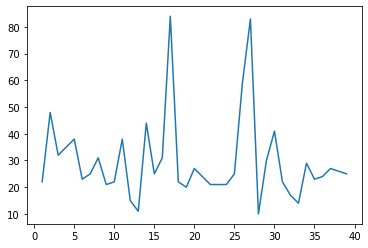

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


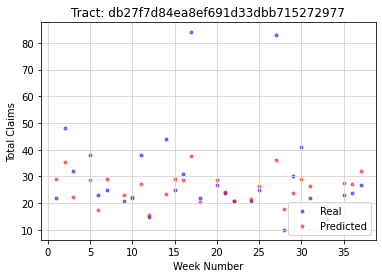

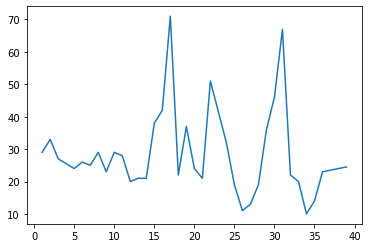

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


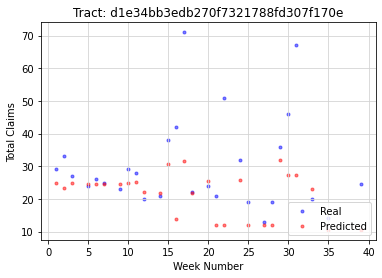

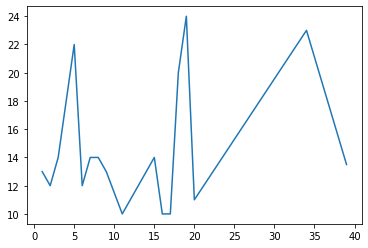

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


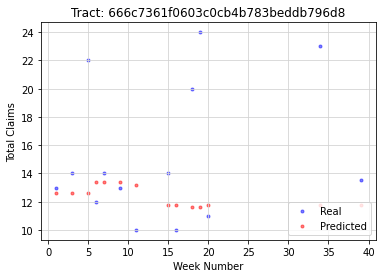

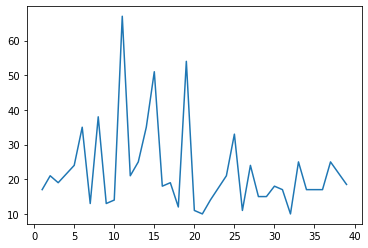

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


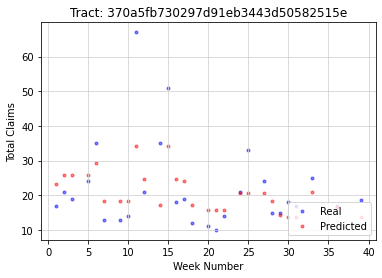

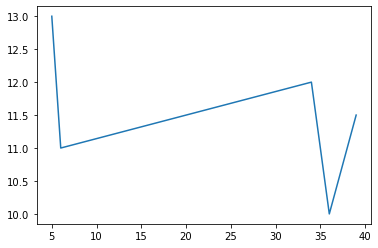

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


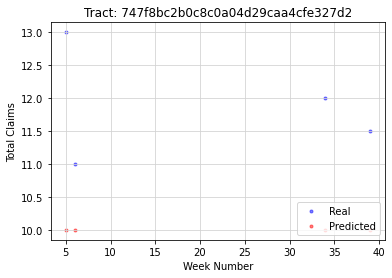

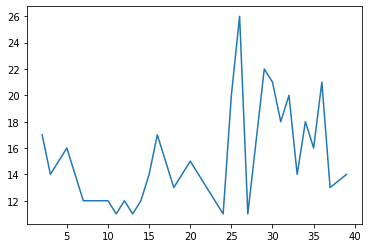

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


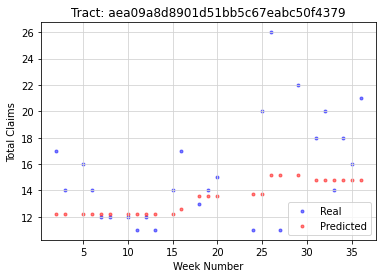

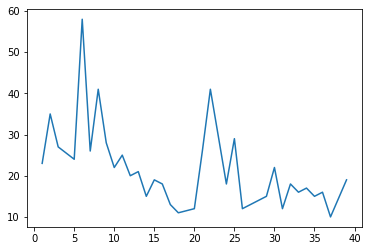

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


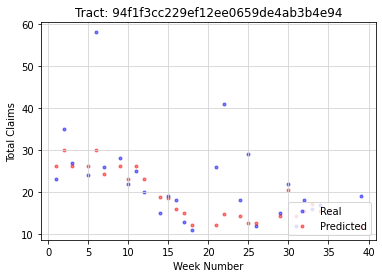

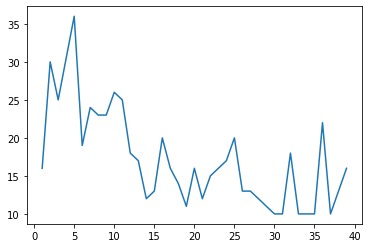

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


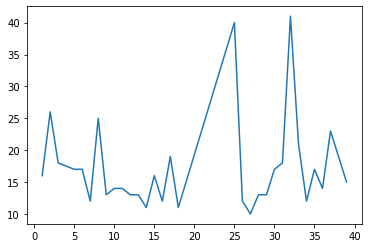

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


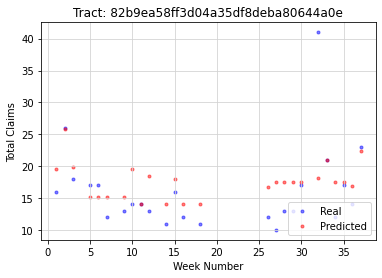

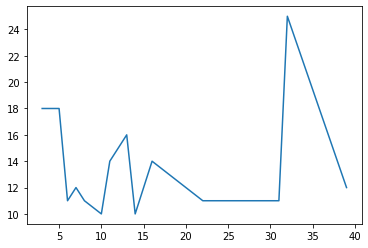

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


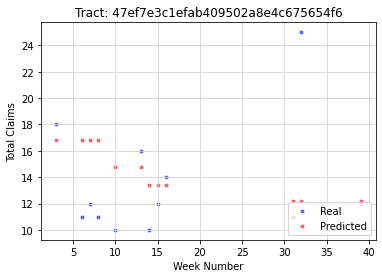

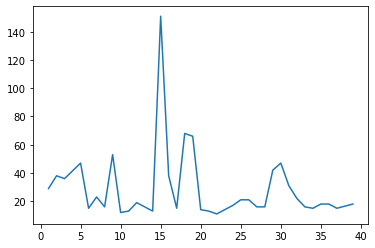

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


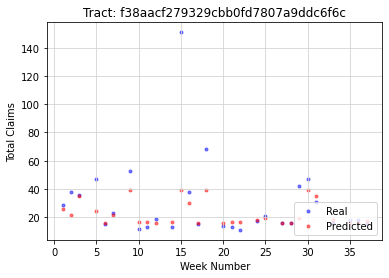

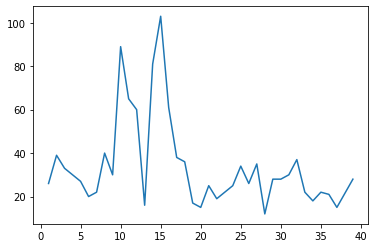

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


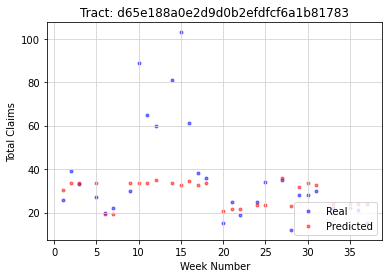

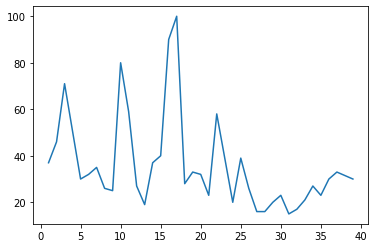

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


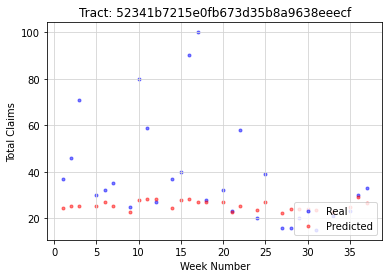

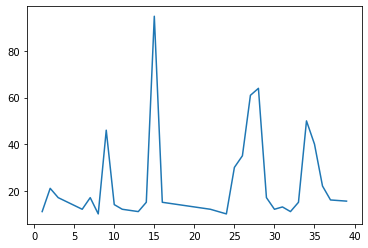

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


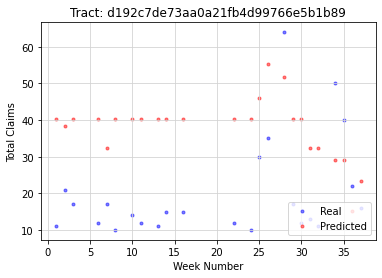

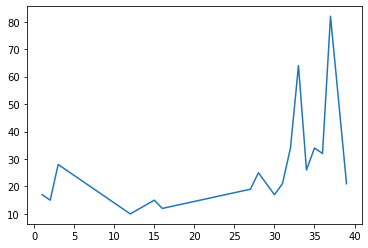

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


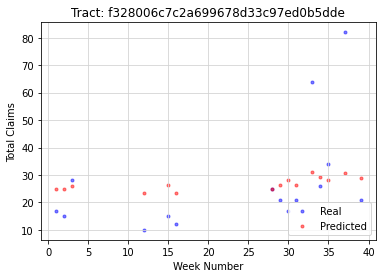

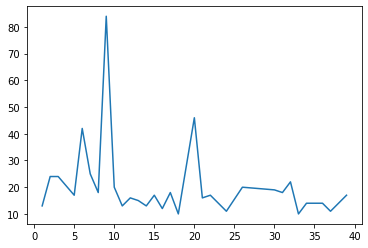

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


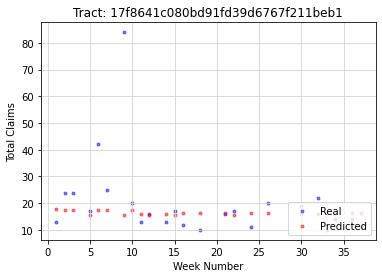

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


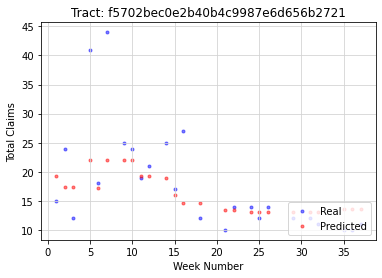

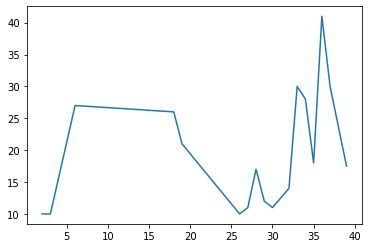

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


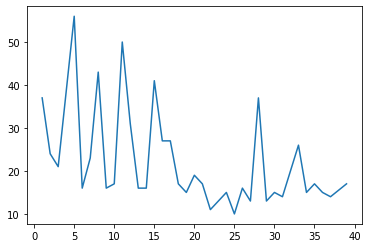

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


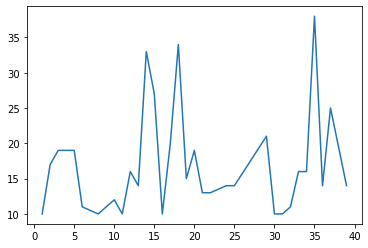

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


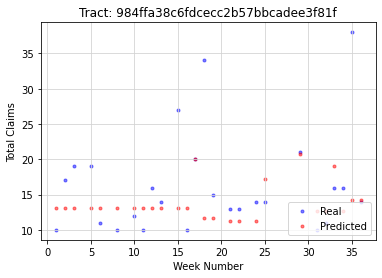

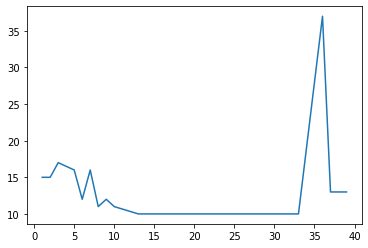

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


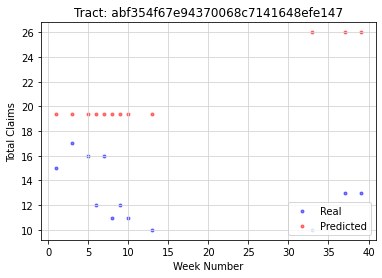

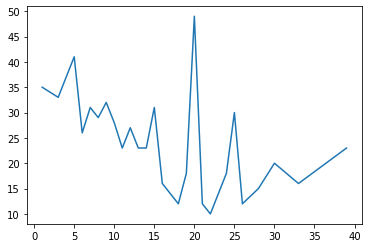

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


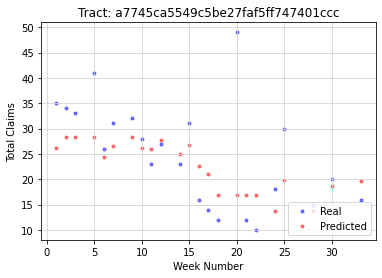

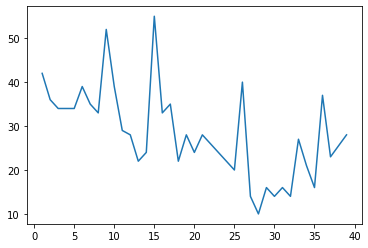

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


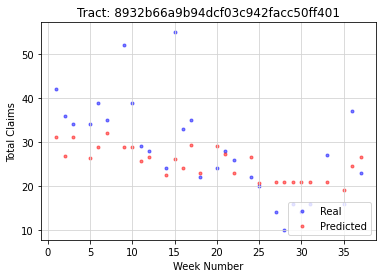

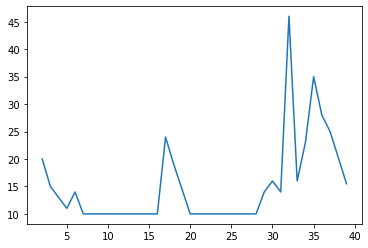

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


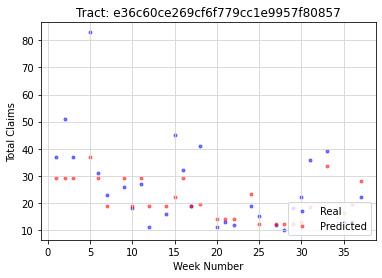

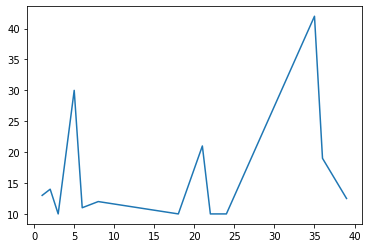

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


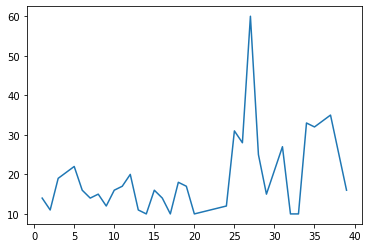

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


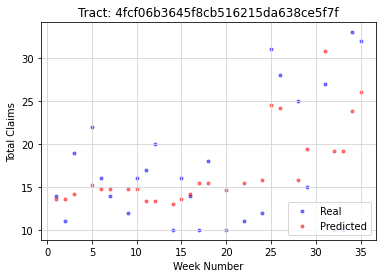

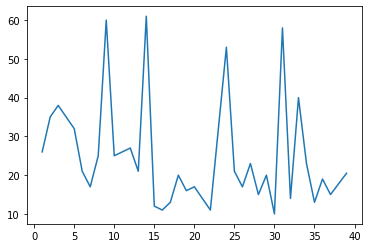

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


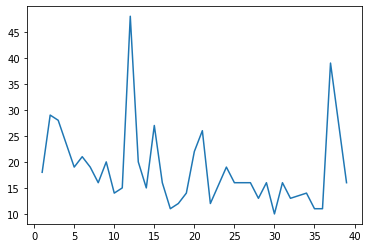

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


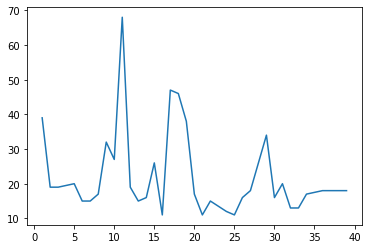

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


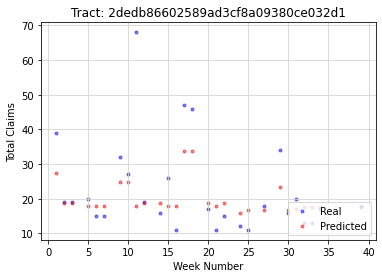

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


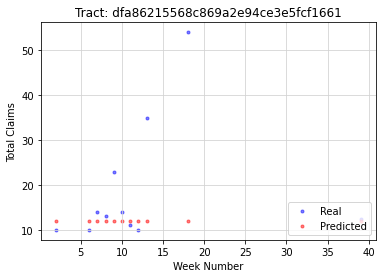

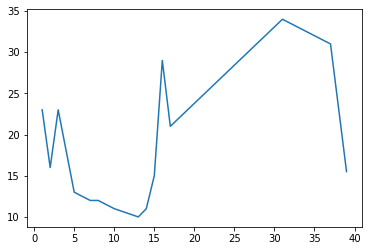

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


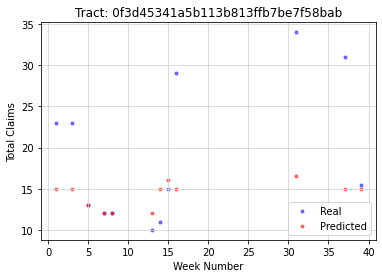

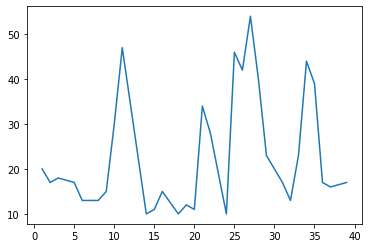

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


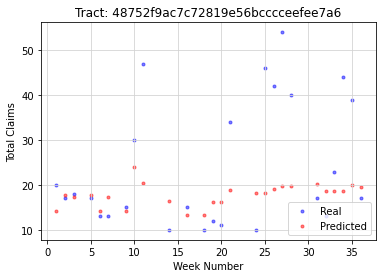

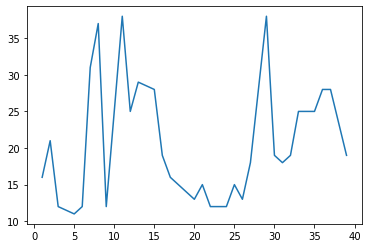

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


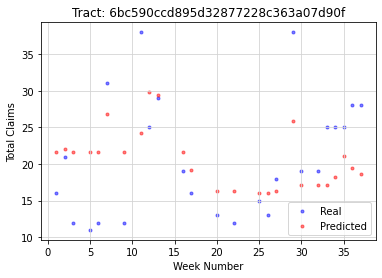

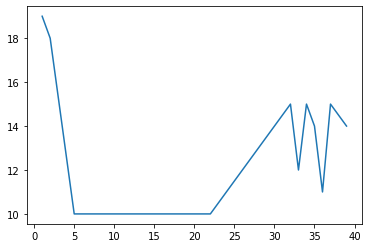

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


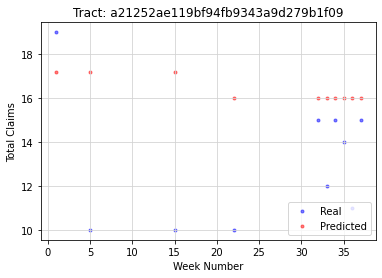

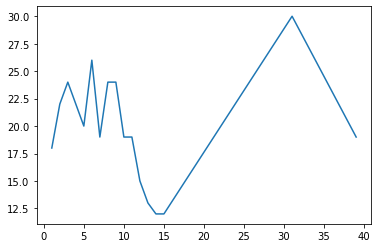

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


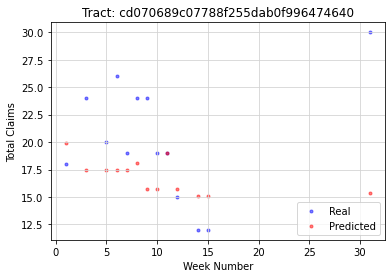

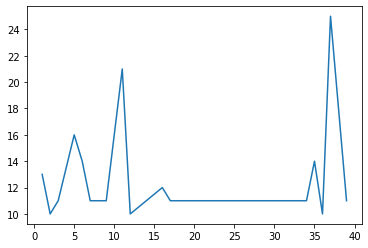

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


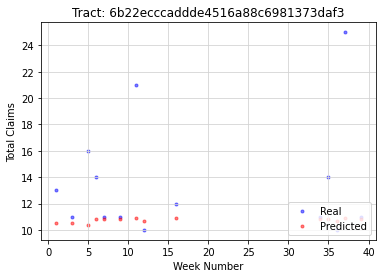

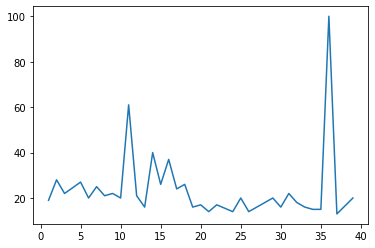

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


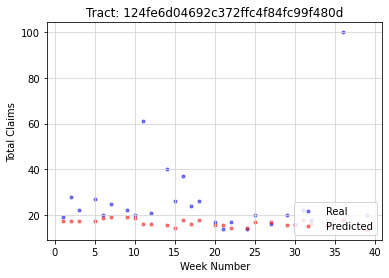

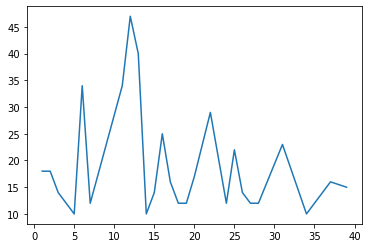

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


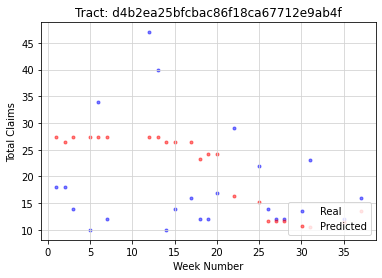

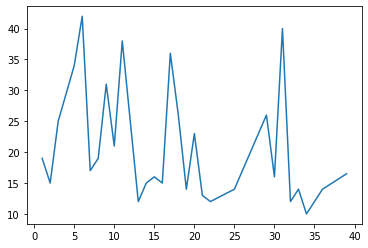

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


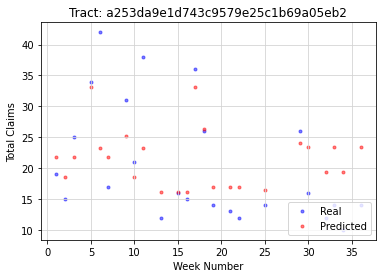

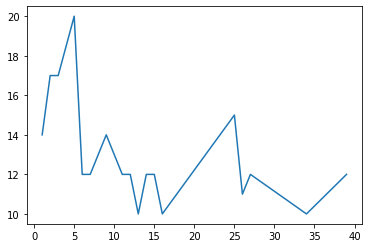

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


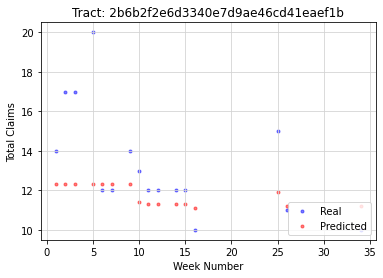

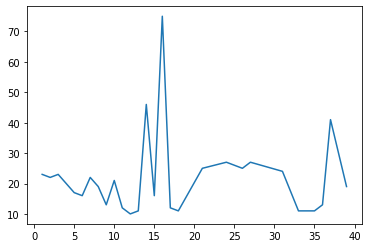

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


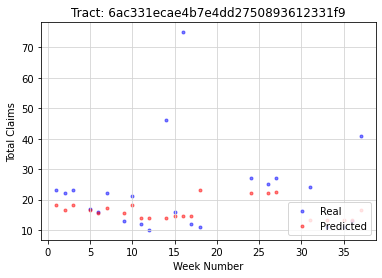

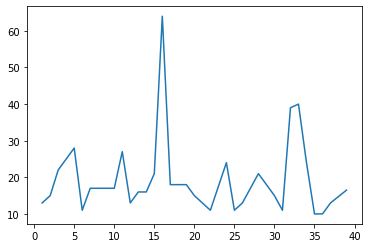

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


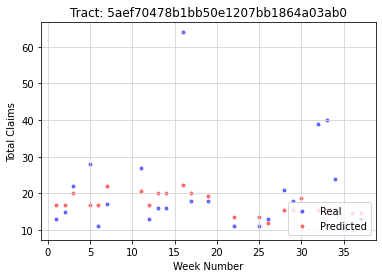

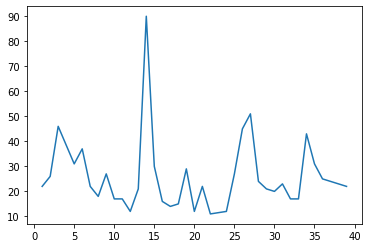

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


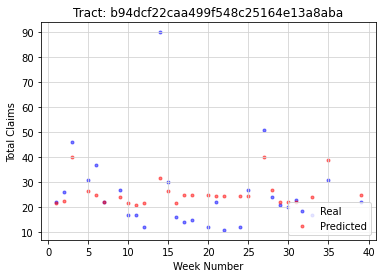

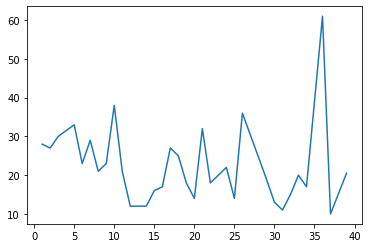

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


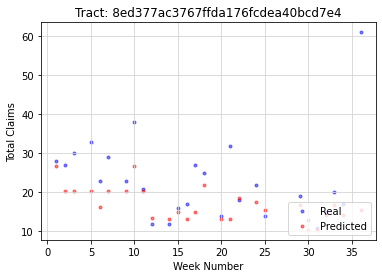

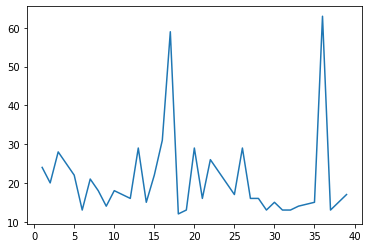

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


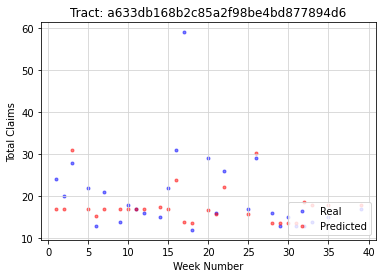

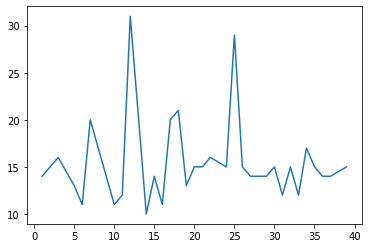

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


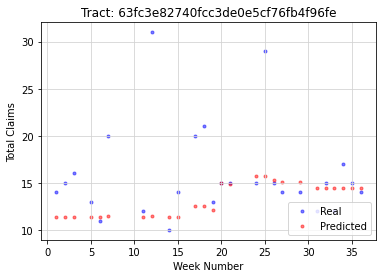

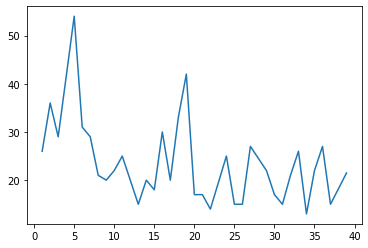

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


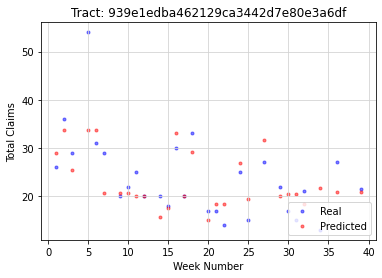

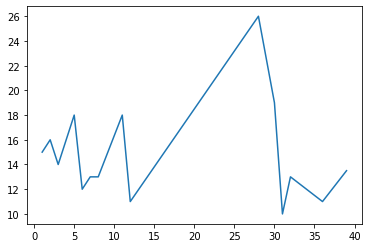

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


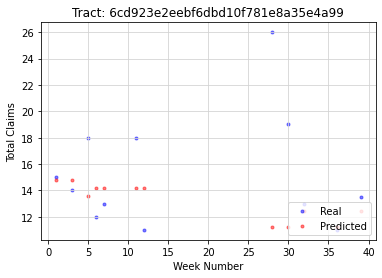

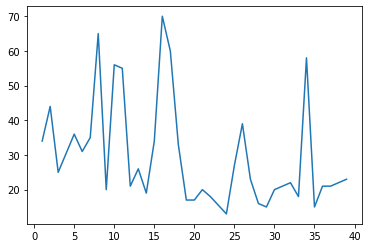

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


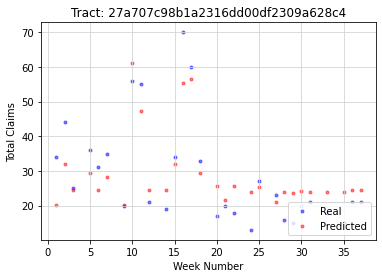

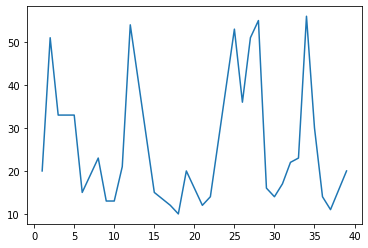

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


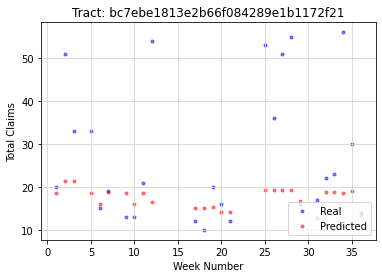

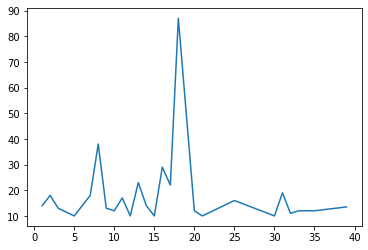

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


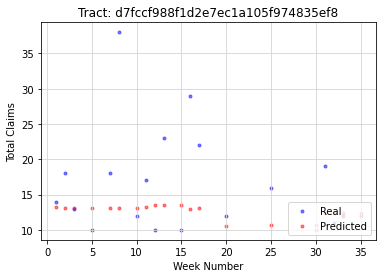

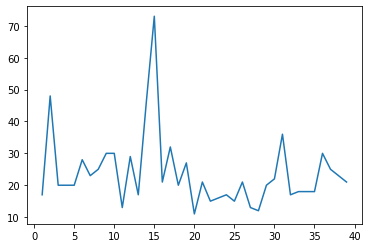

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


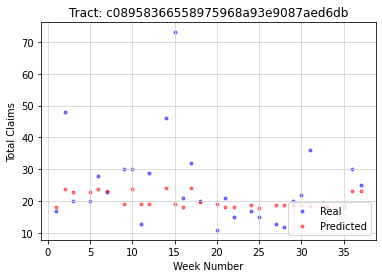

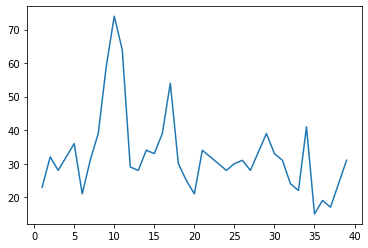

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


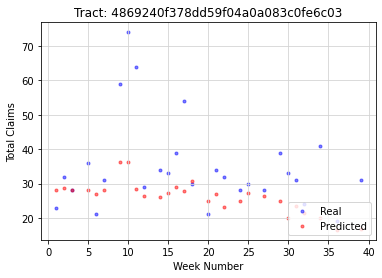

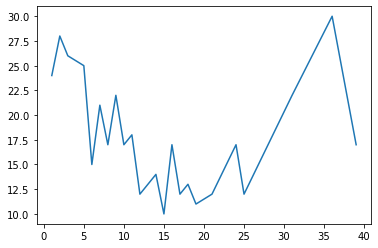

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


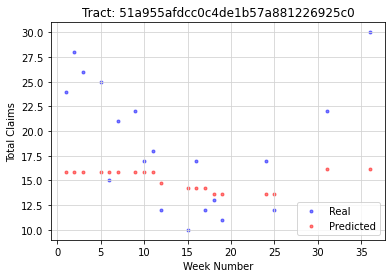

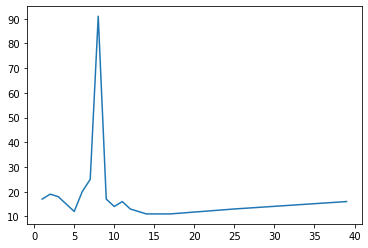

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


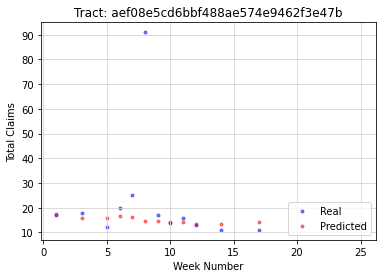

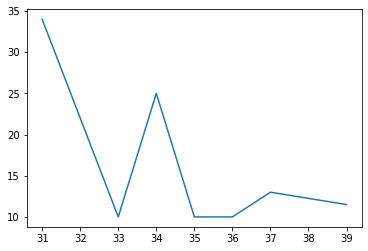

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


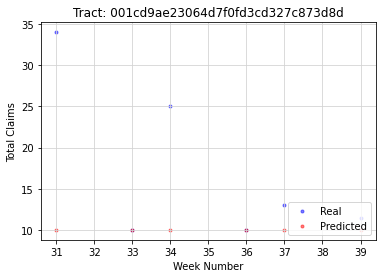

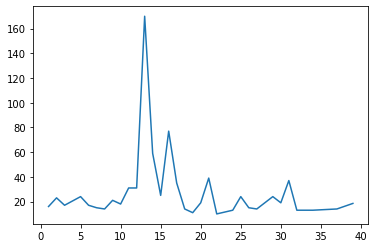

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


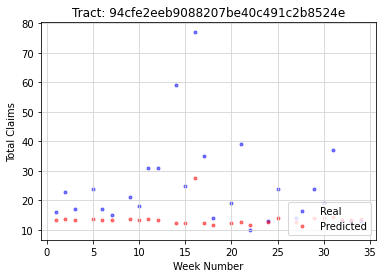

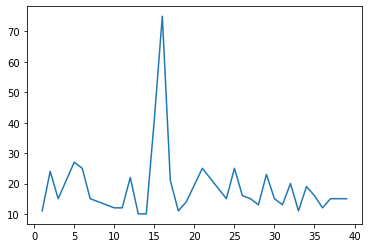

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


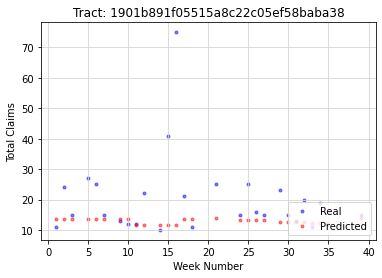

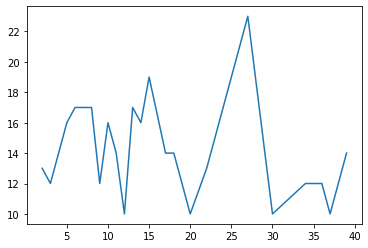

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


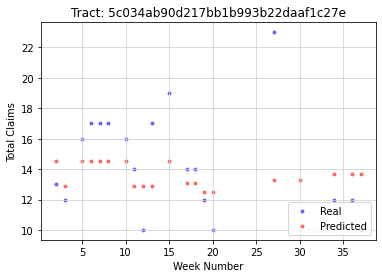

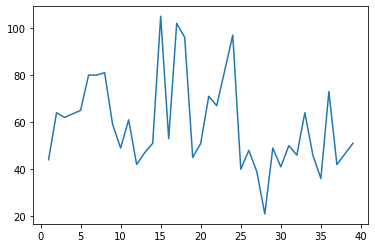

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/4251720613.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()


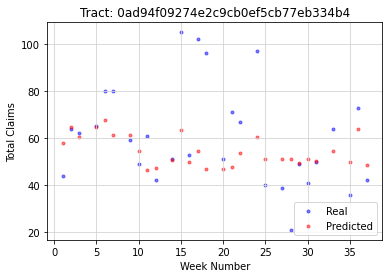

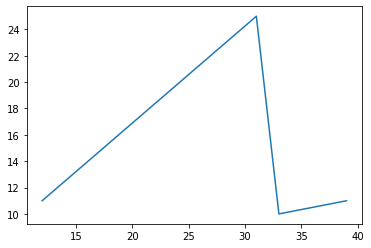

ValueError: With n_samples=4, test_size=0.8 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [38]:
fields = ['uu_id', 'week_number', 'total_claims']
rows = []
for uuid in uuids:
    rows.append([uuid, 39, predict_claims(uuid, 39)])

In [39]:
filename = 'submission_prediction_output.csv'

In [40]:
def predict_claims(uuid, week):
    data = unemployment_data[unemployment_data.uu_id == uuid].copy()
    data.loc[len(data.index)] = [uuid, week, data.total_claims.median(), 0,0,0,0,0,0,0,0]
    # plt.plot(data.week_number, data.total_claims)
    # plt.show()
    
    
    data
    
    X = data.drop(['uu_id','total_claims'], axis = 1)
    y = data[['total_claims']]
    
    
    
    # Splitting data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 101)
    # Train the Model

    regr = RandomForestRegressor(n_estimators = 10, max_depth = 10, random_state = 101)
    regr.fit(X_train, y_train.values.ravel())
    
    predictions = regr.predict(X_test)
    
    result = X_test
    result['total_claims'] = y_test
    result['prediction'] = predictions.tolist()
    
    x_axis = X_test.week_number

    plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
    plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')

    plt.xlabel('Week Number')
    plt.ylabel('Total Claims')
    plt.title('Tract: '+uuid)

    plt.grid(color = '#D3D3D3', linestyle = 'solid')

    plt.legend(loc = 'lower right')

    plt.show()

In [41]:
    result = result.sort_values(by = 'week_number')
    
    return result.prediction.iloc[-1].round()

NameError: name 'result' is not defined

In [42]:
fields = ['uu_id', 'week_number', 'total_claims']
rows = []
for uuid in uuids:
    rows.append([uuid, 39, predict_claims(uuid, 39)])

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/2902208453.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['total_claims'] = y_test
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/2902208453.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['prediction'] = predictions.tolist()
/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_4738/2902208453.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

ValueError: With n_samples=4, test_size=0.8 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [43]:
filename = 'submission_prediction_output.csv'